In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmentenenas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [65]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        if self.decision_rule == "gradient":
            self.last_action = a
            self.last_reward = r
        
        # dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            selected_action = greedyAction(self.q_estimate)
            pass
        if self.decision_rule == "epsilon-greedy":
            selected_action = epsilonGreedyAction(self.q_estimate, self.epsilon)
            pass
        if self.decision_rule == "UCB":
            selected_action = upperConfidenceBoundAction(self.q_estimate, self.UCB_param, self.iteration, self.act_count)
            pass
        if self.decision_rule == "gradient":
            # Tomar H (self.pref) como mi funcion de preferencia que actualiza cuando compara
            # el reward R que obtuve con mi reward promedio estimado R^
            # Debo actualizar dos cosas:
            #    la preferencia de la accion que tome (aumenta o disminuye)
            #    la preferencia de las otras acciones (disminuyen o aumentan)
            if self.iteration == 1:
                # First action decision, without having rewards, so
                # equal preferences for each action
                self.pref = np.empty(self.k)
                self.pref.fill(0)#1.0/self.k)
            else:
                pi = softmax_vect(self.pref)
                # Obs: uso q_estimate como promedio de rewards, ya que acumula llevando la cuenta
                r_diff = self.last_reward - self.q_estimate[self.last_action]
                # one-hot vector with chosen last action
                indicactor = np.where(self.actions==self.last_action, np.ones(self.k), 0.0)
                self.pref += self.lr * r_diff * (indicactor-pi)
            pi = softmax_vect(self.pref)
            selected_action = np.random.choice(self.actions, p=pi)
            if self.iteration % 100 == 2 or self.iteration % 100 == 3 or self.iteration % 100 == 4:
                print(self.iteration, self.pref,pi, selected_action, self.last_action, self.last_reward, r_diff )
            pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        self.act_count[selected_action] += 1
        return selected_action

2 [0. 0.] [0.5 0.5] 0 0 0 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [ 0.01666667 -0.01666667] [0.50833256 0.49166744] 1 0 1 0.6666666666666667
102 [ 0.05858227 -0.05858227] [0.52925767 0.47074233] 1 0 1 0.6666666666666667
103 [ 0.05461284 -0.05461284] [0.5272793 0.4727207] 1 1 1 0.15000000000000002
104 [ 0.07665484 -0.07665484] [0.53825253 0.46174747] 1 1 0 -0.8360655737704917
202 [ 0.26553609 -0.26553609] [0.62973314 0.37026686] 0 1 1 0.20792079207920788
203 [ 0.25857067 -0.25857067] [0.62647907 0.37352093] 0 0 0 -0.37623762376237624
204 [ 0.25161293 -0.25161293] [0.62321712 0.37678288] 0 0 0 -0.37254901960784315
302 [ 0.33645824 -0.33645824] [0.6621559 0.3378441] 0 0 0 -0.41975308641975323
303 [ 0.34619976 -0.34619976] [0.6665005 0.3334995] 0 0 1 0.576687116564417
304 [ 0.35575736 -0.35575736] [0.67073577 0.32926423] 0 0 1 0.5731707317073169
402 [ 0.33657878 -0.33657878] [0.66220983 0.33779017] 0 0 0 -0.39737991266375544
403 [ 0.32989641 -0.32989641] [0.65921384 0.34078616] 0 0 0 -0.395652

202 [-0.17661077  0.17661077] [0.41260143 0.58739857] 0 0 0 -0.31914893617021284
203 [-0.15682471  0.15682471] [0.42222421 0.57777579] 0 0 1 0.6736842105263157
204 [-0.16615338  0.16615338] [0.41767946 0.58232054] 0 0 0 -0.32291666666666674
302 [ 0.15544749 -0.15544749] [0.5771037 0.4228963] 0 0 1 0.6330935251798561
303 [ 0.14774473 -0.14774473] [0.57333951 0.42666049] 0 0 0 -0.3642857142857143
304 [ 0.14002853 -0.14002853] [0.56956021 0.43043979] 1 0 0 -0.3617021276595745
402 [ 0.0875681 -0.0875681] [0.54367248 0.45632752] 0 0 0 -0.3517587939698492
403 [ 0.07958237 -0.07958237] [0.53970739 0.46029261] 0 0 0 -0.35
404 [ 0.07156732 -0.07156732] [0.53572269 0.46427731] 0 0 0 -0.34825870646766166
502 [ 0.08281376 -0.08281376] [0.54131248 0.45868752] 1 1 1 0.1810699588477368
503 [ 0.10488777 -0.10488777] [0.55225241 0.44774759] 0 1 0 -0.8155737704918031
504 [ 0.11949575 -0.11949575] [0.55946511 0.44053489] 0 0 1 0.6525096525096523
602 [ 0.38033736 -0.38033736] [0.68150021 0.31849979] 0 0 1

2 [0. 0.] [0.5 0.5] 0 1 0 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [0. 0.] [0.5 0.5] 0 0 0 0.0
102 [-0.11270957  0.11270957] [0.44388264 0.55611736] 1 1 1 0.22916666666666674
103 [-0.11769193  0.11769193] [0.44142424 0.55857576] 1 1 1 0.22448979591836737
104 [-0.1225476  0.1225476] [0.43903111 0.56096889] 1 1 1 0.21999999999999997
202 [-0.02345788  0.02345788] [0.48827321 0.51172679] 0 1 1 0.18269230769230815
203 [-0.00622626  0.00622626] [0.49688691 0.50311309] 1 0 1 0.6734693877551021
204 [-0.0107219  0.0107219] [0.49463925 0.50536075] 1 1 1 0.18095238095238142
302 [-0.01349771  0.01349771] [0.49325156 0.50674844] 1 0 0 -0.3356643356643355
303 [-0.01768569  0.01768569] [0.49115807 0.50884193] 0 1 1 0.16981132075471728
304 [-0.02616639  0.02616639] [0.48691979 0.51308021] 0 0 0 -0.3333333333333332
402 [ 0.19117007 -0.19117007] [0.59443739 0.40556261] 1 0 1 0.6153846153846152
403 [ 0.18614463 -0.18614463] [0.59201203 0.40798797] 1 1 1 0.16908212560386504
404 [ 0.18116376 -0.18116376] [0.589

302 [ 0.01110966 -0.01110966] [0.5055546 0.4944454] 1 1 1 0.1796875
303 [ 0.00660278 -0.00660278] [0.50330134 0.49669866] 0 1 1 0.17829457364341084
304 [-0.00310282  0.00310282] [0.49844859 0.50155141] 1 0 0 -0.39080459770114934
402 [-0.07364762  0.07364762] [0.46324262 0.53675738] 1 1 1 0.18232044198895014
403 [-0.07784735  0.07784735] [0.46115476 0.53884524] 0 1 1 0.18131868131868123
404 [-0.08784402  0.08784402] [0.45619062 0.54380938] 0 0 0 -0.37104072398190036
502 [ 0.02300384 -0.02300384] [0.51149989 0.48850011] 1 0 0 -0.38805970149253716
503 [ 0.01841345 -0.01841345] [0.50920569 0.49079431] 1 1 1 0.17948717948717952
504 [ 0.0138631 -0.0138631] [0.50693111 0.49306889] 0 1 1 0.17872340425531918
602 [-0.15827278  0.15827278] [0.42151785 0.57848215] 1 0 0 -0.35947712418300654
603 [-0.16218891  0.16218891] [0.41960921 0.58039079] 1 1 1 0.1858108108108102
604 [-0.16607418  0.16607418] [0.41771799 0.58228201] 1 1 1 0.18518518518518456
702 [-0.19214039  0.19214039] [0.40509484 0.5949051

902 [-0.52974507  0.52974507] [0.2574069 0.7425931] 1 1 1 0.2165354330708662
903 [-0.53252648  0.53252648] [0.25634501 0.74365499] 1 1 1 0.21611001964636545
904 [-0.53529099  0.53529099] [0.25529243 0.74470757] 1 1 1 0.21568627450980393
2 [0. 0.] [0.5 0.5] 1 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 1 1 0.0
4 [0. 0.] [0.5 0.5] 0 0 1 0.0
102 [ 0.08968975 -0.08968975] [0.54472501 0.45527499] 1 0 0 -0.37931034482758613
103 [ 0.08597571 -0.08597571] [0.54288225 0.45711775] 1 1 1 0.13636363636363635
104 [ 0.10889741 -0.10889741] [0.55423449 0.44576551] 1 1 0 -0.8444444444444444
202 [ 0.20106357 -0.20106357] [0.59919862 0.40080138] 0 1 1 0.2499999999999999
203 [ 0.21436289 -0.21436289] [0.60556935 0.39443065] 0 0 1 0.6636363636363637
204 [ 0.20778904 -0.20778904] [0.60242464 0.39757536] 0 0 0 -0.33333333333333326
302 [ 0.14403277 -0.14403277] [0.57152248 0.42847752] 1 1 1 0.24999999999999978
303 [ 0.13694412 -0.13694412] [0.56804721 0.43195279] 0 1 1 0.24806201550387574
304 [ 0.13024141 -0.13024141] [0.

402 [-0.0711964  0.0711964] [0.46446183 0.53553817] 1 1 0 -0.7010869565217386
403 [-0.07810056  0.07810056] [0.46102892 0.53897108] 1 1 1 0.2972972972972978
404 [-0.08491685  0.08491685] [0.45764334 0.54235666] 0 1 1 0.2956989247311833
502 [-0.00297676  0.00297676] [0.49851163 0.50148837] 0 1 0 -0.7203389830508471
503 [ 0.01163428 -0.01163428] [0.50581688 0.49418312] 1 0 1 0.5827067669172932
504 [ 0.00459126 -0.00459126] [0.50229561 0.49770439] 0 1 1 0.2784810126582282
602 [ 0.08205042 -0.08205042] [0.54093339 0.45906661] 0 1 1 0.27402135231316715
603 [ 0.07211113 -0.07211113] [0.5359932 0.4640068] 0 0 0 -0.43302180685358266
604 [ 0.06209607 -0.06209607] [0.53100819 0.46899181] 0 0 0 -0.43167701863354047
702 [-0.14581414  0.14581414] [0.42760528 0.57239472] 0 1 1 0.2666666666666667
703 [-0.12904236  0.12904236] [0.43583459 0.56416541] 0 0 1 0.5860215053763442
704 [-0.14068867  0.14068867] [0.43011614 0.56988386] 1 0 0 -0.4128686327077747
802 [-0.24230977  0.24230977] [0.38116188 0.6188

802 [-0.50643453  0.50643453] [0.26641875 0.73358125] 1 0 0 -0.3476923076923079
803 [-0.50864072  0.50864072] [0.26555728 0.73444272] 1 1 1 0.16561844863731634
804 [-0.51083518  0.51083518] [0.26470216 0.73529784] 0 1 1 0.16527196652719645
902 [-0.51654503  0.51654503] [0.26248547 0.73751453] 0 1 1 0.1699819168173594
903 [-0.4924543  0.4924543] [0.2719189 0.7280811] 1 0 1 0.653295128939828
904 [-0.48118979  0.48118979] [0.27640202 0.72359798] 1 1 0 -0.8285198555956683
2 [0. 0.] [0.5 0.5] 0 1 0 0.0
3 [0. 0.] [0.5 0.5] 1 0 0 0.0
4 [-0.0125  0.0125] [0.49375033 0.50624967] 0 1 1 0.5
102 [-0.12331193  0.12331193] [0.43865466 0.56134534] 1 1 1 0.21818181818181825
103 [-0.1280118  0.1280118] [0.43634145 0.56365855] 0 1 1 0.2142857142857144
104 [-0.13640671  0.13640671] [0.43221653 0.56778347] 0 0 0 -0.297872340425532
202 [-0.07699025  0.07699025] [0.46158075 0.53841925] 0 0 0 -0.35555555555555574
203 [-0.05983184  0.05983184] [0.47011973 0.52988027] 1 0 1 0.6373626373626372
204 [-0.06444909 

102 [ 0.02128661 -0.02128661] [0.5106417 0.4893583] 1 0 1 0.5272727272727273
103 [ 0.0424728 -0.0424728] [0.52122364 0.47877636] 1 1 0 -0.8297872340425531
104 [ 0.03812927 -0.03812927] [0.5190554 0.4809446] 0 1 1 0.16666666666666685
202 [-0.03961151  0.03961151] [0.4802046 0.5197954] 0 1 1 0.19791666666666652
203 [-0.04990934  0.04990934] [0.47506603 0.52493397] 0 0 0 -0.39622641509433965
204 [-0.03421038  0.03421038] [0.48290148 0.51709852] 1 0 1 0.5981308411214953
302 [ 0.05185488 -0.05185488] [0.52590422 0.47409578] 1 0 1 0.5796178343949043
303 [ 0.04659584 -0.04659584] [0.52328107 0.47671893] 0 1 1 0.19999999999999984
304 [ 0.03663905 -0.03663905] [0.51831133 0.48168867] 1 0 0 -0.41772151898734194
402 [ 0.10289486 -0.10289486] [0.55126663 0.44873337] 0 0 0 -0.43055555555555564
403 [ 0.11561242 -0.11561242] [0.55755003 0.44244997] 1 0 1 0.5668202764976957
404 [ 0.11006689 -0.11006689] [0.55481228 0.44518772] 1 1 1 0.1989247311827953
502 [ 0.08019449 -0.08019449] [0.54001151 0.459988

602 [-0.19959078  0.19959078] [0.401509 0.598491] 1 0 0 -0.40983606557377045
603 [-0.18336819  0.18336819] [0.40932986 0.59067014] 1 1 0 -0.8080808080808082
604 [-0.18728292  0.18728292] [0.40743822 0.59256178] 1 1 1 0.1912751677852348
702 [-0.21304102  0.21304102] [0.39506229 0.60493771] 0 0 0 -0.4067796610169491
703 [-0.1951485  0.1951485] [0.40364581 0.59635419] 1 0 1 0.591549295774648
704 [-0.19903417  0.19903417] [0.40177653 0.59822347] 0 1 1 0.19252873563218387
802 [-0.15540517  0.15540517] [0.42291696 0.57708304] 0 0 1 0.5954198473282443
803 [-0.16704936  0.16704936] [0.41724368 0.58275632] 0 0 0 -0.4035532994923858
804 [-0.1497142  0.1497142] [0.42569722 0.57430278] 1 0 1 0.5949367088607596
902 [-0.17240789  0.17240789] [0.41464014 0.58535986] 1 1 0 -0.8017241379310341
903 [-0.15582228  0.15582228] [0.42271337 0.57728663] 1 1 0 -0.7999999999999997
904 [-0.16004034  0.16004034] [0.42065608 0.57934392] 1 1 1 0.19957081545064403
2 [0. 0.] [0.5 0.5] 0 0 0 0.0
3 [ 0.0125 -0.0125] [0

202 [ 0.10940617 -0.10940617] [0.55448586 0.44551414] 0 1 1 0.19101123595505598
203 [ 0.10073244 -0.10073244] [0.55019655 0.44980345] 0 0 0 -0.38938053097345143
204 [ 0.09205202 -0.09205202] [0.54589645 0.45410355] 0 0 0 -0.38596491228070184
302 [-0.01664553  0.01664553] [0.491678 0.508322] 1 1 1 0.20610687022900764
303 [-0.02167406  0.02167406] [0.48916467 0.51083533] 0 1 1 0.20454545454545459
304 [-0.00494495  0.00494495] [0.49752755 0.50247245] 0 0 1 0.6549707602339181
402 [ 0.0485905 -0.0485905] [0.52427615 0.47572385] 0 1 1 0.21910112359550582
403 [ 0.064094 -0.064094] [0.53200319 0.46799681] 1 0 1 0.6517857142857143
404 [ 0.05829843 -0.05829843] [0.52911624 0.47088376] 1 1 1 0.2178770949720672
502 [ 0.0248014 -0.0248014] [0.51239816 0.48760184] 0 1 0 -0.7982456140350873
503 [ 0.04055058 -0.04055058] [0.52026419 0.47973581] 0 0 1 0.6459854014598538
504 [ 0.03208979 -0.03208979] [0.51603939 0.48396061] 1 0 0 -0.35272727272727283
602 [ 0.04947048 -0.04947048] [0.52471508 0.47528492]

302 [ 0.02737152 -0.02737152] [0.51368234 0.48631766] 0 0 0 -0.4189944134078212
303 [ 0.04142069 -0.04142069] [0.52069851 0.47930149] 0 0 1 0.5777777777777778
304 [ 0.05519068 -0.05519068] [0.52756736 0.47243264] 1 0 1 0.5745856353591161
402 [ 0.18363454 -0.18363454] [0.59079893 0.40920107] 1 0 1 0.5769230769230771
403 [ 0.17695289 -0.17695289] [0.5875644 0.4124356] 0 1 1 0.22619047619047639
404 [ 0.16826541 -0.16826541] [0.58334757 0.41665243] 0 0 0 -0.42127659574468074
502 [ 0.11274807 -0.11274807] [0.55613637 0.44386363] 0 0 1 0.5816326530612246
503 [ 0.10349464 -0.10349464] [0.55156335 0.44843665] 1 0 0 -0.4169491525423728
504 [ 0.09752821 -0.09752821] [0.54861008 0.45138992] 0 1 1 0.21634615384615385
602 [ 0.03233364 -0.03233364] [0.51616119 0.48383881] 0 0 0 -0.4092219020172909
603 [ 0.02246222 -0.02246222] [0.51122922 0.48877078] 1 0 0 -0.4080459770114941
604 [ 0.01694896 -0.01694896] [0.50847367 0.49152633] 0 1 1 0.21568627450980382
702 [-0.0328553  0.0328553] [0.48357826 0.516

2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [0. 0.] [0.5 0.5] 0 0 0 0.0
102 [ 0.20226292 -0.20226292] [0.59977456 0.40022544] 0 0 0 -0.37037037037037035
103 [ 0.1949861 -0.1949861] [0.59627601 0.40372399] 0 0 0 -0.3636363636363636
104 [ 0.20760247 -0.20760247] [0.60233527 0.39766473] 0 0 1 0.625
202 [ 0.25444216 -0.25444216] [0.6245449 0.3754551] 0 1 0 -0.8850574712643676
203 [ 0.24725955 -0.24725955] [0.62117044 0.37882956] 0 0 0 -0.38260869565217376
204 [ 0.24007485 -0.24007485] [0.61778322 0.38221678] 0 0 0 -0.3793103448275861
302 [ 0.30990939 -0.30990939] [0.65017733 0.34982267] 0 0 1 0.5862068965517242
303 [ 0.30271304 -0.30271304] [0.64689672 0.35310328] 0 0 0 -0.4114285714285713
304 [ 0.31304532 -0.31304532] [0.6516025 0.3483975] 1 0 1 0.5852272727272728
402 [ 0.34068085 -0.34068085] [0.66404255 0.33595745] 0 0 0 -0.3795918367346939
403 [ 0.35106003 -0.35106003] [0.66865765 0.33134235] 1 0 1 0.6178861788617886
404 [ 0.34658811 -0.34658811] [0.66667312 0.3333268

902 [-0.24927046  0.24927046] [0.37788362 0.62211638] 1 1 0 -0.786697247706422
903 [-0.23444047  0.23444047] [0.38488114 0.61511886] 0 1 0 -0.7848970251716247
904 [-0.24678245  0.24678245] [0.37905413 0.62094587] 0 0 0 -0.40128755364806895
2 [0. 0.] [0.5 0.5] 1 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 1 1 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
102 [ 0.01933421 -0.01933421] [0.5096659 0.4903341] 0 1 1 0.1590909090909094
103 [ 0.03370607 -0.03370607] [0.51684665 0.48315335] 1 0 1 0.5862068965517242
104 [ 0.02968615 -0.02968615] [0.51483872 0.48516128] 0 1 1 0.1555555555555559
202 [ 0.21363135 -0.21363135] [0.60521984 0.39478016] 1 0 1 0.5357142857142856
203 [ 0.23716767 -0.23716767] [0.61640936 0.38359064] 1 1 0 -0.7777777777777777
204 [ 0.23039394 -0.23039394] [0.61320107 0.38679893] 0 1 1 0.2197802197802199
302 [ 0.28799171 -0.28799171] [0.64014267 0.35985733] 0 0 0 -0.4399999999999999
303 [ 0.28011983 -0.28011983] [0.63650799 0.36349201] 0 0 0 -0.4374999999999999
304 [ 0.27221337 -0.27221337] [0.6328

502 [ 0.15030046 -0.15030046] [0.57458941 0.42541059] 0 1 0 -0.7725118483412322
503 [ 0.1416022 -0.1416022] [0.57033165 0.42966835] 0 0 0 -0.40893470790378017
504 [ 0.13284697 -0.13284697] [0.56603547 0.43396453] 1 0 0 -0.40753424657534254
602 [ 0.12096079 -0.12096079] [0.56018714 0.43981286] 1 1 1 0.21621621621621623
603 [ 0.14282963 -0.14282963] [0.57093312 0.42906688] 0 1 0 -0.7807692307692308
604 [ 0.13394807 -0.13394807] [0.56657634 0.43342366] 0 0 0 -0.41399416909620995
702 [ 0.19130924 -0.19130924] [0.59450449 0.40549551] 0 1 1 0.2211221122112208
703 [ 0.20304726 -0.20304726] [0.60015105 0.39984895] 0 0 1 0.5789473684210527
704 [ 0.2145929 -0.2145929] [0.60567923 0.39432077] 0 0 1 0.5775000000000001
802 [ 0.16209472 -0.16209472] [0.58034491 0.41965509] 0 0 0 -0.42060085836909855
803 [ 0.17422608 -0.17422608] [0.58624218 0.41375782] 1 0 1 0.5781584582441115
804 [ 0.16785767 -0.16785767] [0.58314936 0.41685064] 0 1 1 0.21726190476190455
902 [ 0.04328794 -0.04328794] [0.52163046 0.

702 [ 0.27977894 -0.27977894] [0.63635024 0.36364976] 0 0 1 0.5837004405286346
703 [ 0.27222622 -0.27222622] [0.63284756 0.36715244] 0 0 0 -0.41538461538461524
704 [ 0.26461747 -0.26461747] [0.62930465 0.37069535] 0 0 0 -0.41447368421052616
802 [ 0.08561729 -0.08561729] [0.54270435 0.45729565] 0 1 1 0.22666666666666646
803 [ 0.07618898 -0.07618898] [0.53802095 0.46197905] 0 0 0 -0.4123505976095615
804 [ 0.06668305 -0.06668305] [0.53329219 0.46670781] 1 0 0 -0.4115308151093437
902 [ 0.09101419 -0.09101419] [0.54538186 0.45461814] 0 1 1 0.22157434402332343
903 [ 0.08153959 -0.08153959] [0.54067968 0.45932032] 1 0 0 -0.41681574239713737
904 [ 0.10252236 -0.10252236] [0.55108233 0.44891767] 0 1 0 -0.7761627906976746
2 [0. 0.] [0.5 0.5] 1 0 0 0.0
3 [0. 0.] [0.5 0.5] 1 1 1 0.0
4 [ 0.0125 -0.0125] [0.50624967 0.49375033] 0 1 0 -0.5
102 [ 0.02109805 -0.02109805] [0.51054746 0.48945254] 0 0 0 -0.3888888888888888
103 [ 0.01175395 -0.01175395] [0.50587671 0.49412329] 0 0 0 -0.3818181818181817
104

502 [-0.32565956  0.32565956] [0.34269234 0.65730766] 1 1 1 0.20567375886524808
503 [-0.32917125  0.32917125] [0.34111204 0.65888796] 0 1 1 0.204946996466431
504 [-0.30880563  0.30880563] [0.35032493 0.64967507] 0 0 1 0.6181818181818182
602 [-0.23854893  0.23854893] [0.38293766 0.61706234] 1 0 0 -0.3893129770992365
603 [-0.24249094  0.24249094] [0.38107642 0.61892358] 1 1 1 0.2058823529411763
604 [-0.24640228  0.24640228] [0.37923311 0.62076689] 1 1 1 0.2052785923753664
702 [-0.20072359  0.20072359] [0.40096469 0.59903531] 0 0 1 0.5966101694915256
703 [-0.18291443  0.18291443] [0.4095493 0.5904507] 0 0 1 0.5945945945945947
704 [-0.19484273  0.19484273] [0.40379302 0.59620698] 0 0 0 -0.404040404040404
802 [-0.12733083  0.12733083] [0.43667644 0.56332356] 0 0 0 -0.41369047619047616
803 [-0.11086574  0.11086574] [0.44479313 0.55520687] 1 0 1 0.5845697329376855
804 [-0.09292129  0.09292129] [0.45367261 0.54632739] 1 1 0 -0.8068669527896996
902 [-0.0720826  0.0720826] [0.46402099 0.53597901

902 [-0.31806765  0.31806765] [0.34612068 0.65387932] 0 0 1 0.5510204081632655
903 [-0.33271336  0.33271336] [0.33952163 0.66047837] 1 0 0 -0.4479638009049772
904 [-0.31949337  0.31949337] [0.34547562 0.65452438] 1 1 0 -0.7787418655097612
2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [ 0.0125 -0.0125] [0.50624967 0.49375033] 0 0 1 0.5
102 [-0.21825158  0.21825158] [0.39257451 0.60742549] 1 0 1 0.6415094339622641
103 [-0.22145627  0.22145627] [0.39104719 0.60895281] 1 1 1 0.16326530612244894
104 [-0.22458465  0.22458465] [0.38955829 0.61044171] 1 1 1 0.15999999999999992
202 [-0.17209397  0.17209397] [0.41479254 0.58520746] 1 0 0 -0.38947368421052625
203 [-0.15484325  0.15484325] [0.42319126 0.57680874] 0 1 0 -0.8317757009345794
204 [-0.13741882  0.13741882] [0.43171985 0.56828015] 1 0 1 0.6041666666666667
302 [ 0.07662158 -0.07662158] [0.53823599 0.46176401] 0 0 1 0.5531914893617023
303 [ 0.08930383 -0.08930383] [0.54453359 0.45546641] 0 0 1 0.5492957746478875
304 [ 0.07

102 [-0.03661311  0.03661311] [0.48170162 0.51829838] 1 0 0 -0.30769230769230765
103 [-0.04094842  0.04094842] [0.47953723 0.52046277] 1 1 1 0.18000000000000016
104 [-0.04517963  0.04517963] [0.47742554 0.52257446] 1 1 1 0.17647058823529427
202 [ 0.03503689 -0.03503689] [0.51751128 0.48248872] 0 1 1 0.19791666666666663
203 [ 0.02707128 -0.02707128] [0.51353233 0.48646767] 0 0 0 -0.33018867924528306
204 [ 0.01911503 -0.01911503] [0.50955635 0.49044365] 1 0 0 -0.3271028037383178
302 [ 0.0708285 -0.0708285] [0.53535515 0.46464485] 0 1 1 0.1793103448275858
303 [ 0.06254184 -0.06254184] [0.53123021 0.46876979] 0 0 0 -0.356687898089172
304 [ 0.05423453 -0.05423453] [0.52709071 0.47290929] 1 0 0 -0.3544303797468355
402 [ 0.2713581 -0.2713581] [0.63244405 0.36755595] 0 1 1 0.19553072625698298
403 [ 0.26410588 -0.26410588] [0.62906593 0.37093407] 0 0 0 -0.3946188340807175
404 [ 0.25681967 -0.25681967] [0.62565923 0.37434077] 0 0 0 -0.3928571428571429
502 [ 0.41290752 -0.41290752] [0.69546931 0.

302 [-0.12977521  0.12977521] [0.43547423 0.56452577] 1 0 1 0.5696969696969696
303 [-0.11308733  0.11308733] [0.44369615 0.55630385] 1 1 0 -0.7664233576642336
304 [-0.11823163  0.11823163] [0.44115811 0.55884189] 0 1 1 0.2318840579710144
402 [-0.30849532  0.30849532] [0.35046619 0.64953381] 1 1 1 0.21674876847290647
403 [-0.29483745  0.29483745] [0.35670945 0.64329055] 1 1 0 -0.7794117647058822
404 [-0.29875255  0.29875255] [0.3549147 0.6450853] 1 1 1 0.2195121951219513
502 [-0.41100493  0.41100493] [0.30533719 0.69466281] 1 0 1 0.6061946902654867
503 [-0.39894632  0.39894632] [0.31047648 0.68952352] 1 1 0 -0.7898550724637678
504 [-0.4021968  0.4021968] [0.30908647 0.69091353] 1 1 1 0.20938628158844796
602 [-0.49786075  0.49786075] [0.26978346 0.73021654] 1 1 1 0.20000000000000018
603 [-0.50055079  0.50055079] [0.26872489 0.73127511] 1 1 1 0.19942196531791923
604 [-0.50322255  0.50322255] [0.26767613 0.73232387] 0 1 1 0.19884726224783877
702 [-0.6241646  0.6241646] [0.2229895 0.7770105

302 [ 0.23351904 -0.23351904] [0.61468247 0.38531753] 1 0 0 -0.409090909090909
303 [ 0.25717944 -0.25717944] [0.62582774 0.37417226] 0 1 0 -0.76984126984127
304 [ 0.26817207 -0.26817207] [0.63096156 0.36903844] 0 0 1 0.5875706214689267
402 [ 0.31155574 -0.31155574] [0.65092587 0.34907413] 0 0 0 -0.4411764705882352
403 [ 0.32126847 -0.32126847] [0.65532671 0.34467329] 1 0 1 0.5564853556485356
404 [ 0.31427565 -0.31427565] [0.6521609 0.3478391] 0 1 1 0.2134146341463412
502 [ 0.27911403 -0.27911403] [0.63604245 0.36395755] 1 0 1 0.5633333333333335
503 [ 0.27234427 -0.27234427] [0.63290242 0.36709758] 0 1 1 0.21287128712871284
504 [ 0.28264984 -0.28264984] [0.63767789 0.36232211] 1 0 1 0.5614617940199337
602 [ 0.36483409 -0.36483409] [0.67473245 0.32526755] 0 1 0 -0.7744680851063829
603 [ 0.35774379 -0.35774379] [0.67161258 0.32838742] 0 0 0 -0.43596730245231596
604 [ 0.36697969 -0.36697969] [0.67567353 0.32432647] 1 0 1 0.5625000000000001
702 [ 0.17041761 -0.17041761] [0.58439339 0.415606

602 [-0.13684296  0.13684296] [0.43200243 0.56799757] 1 1 1 0.23180592991913762
603 [-0.14183654  0.14183654] [0.4295535 0.5704465] 1 1 1 0.23118279569892486
604 [-0.1467885  0.1467885] [0.42712839 0.57287161] 1 1 1 0.2305630026809653
702 [-0.27993616  0.27993616] [0.363577 0.636423] 0 1 1 0.22041763341067322
703 [-0.26232298  0.26232298] [0.3717665 0.6282335] 1 0 1 0.5535055350553507
704 [-0.26641069  0.26641069] [0.36985909 0.63014091] 1 1 1 0.21990740740740777
802 [-0.24640106  0.24640106] [0.37923368 0.62076632] 0 0 0 -0.44444444444444425
803 [-0.22921372  0.22921372] [0.38735895 0.61264105] 1 0 1 0.5537459283387625
804 [-0.21421918  0.21421918] [0.3944993 0.6055007] 1 1 0 -0.7741935483870965
902 [-0.1748057  0.1748057] [0.41347666 0.58652334] 1 0 0 -0.44637681159420284
903 [-0.17955659  0.17955659] [0.41117425 0.58882575] 0 1 1 0.22980251346499125
904 [-0.19266052  0.19266052] [0.40484417 0.59515583] 1 0 0 -0.4450867052023121
2 [0. 0.] [0.5 0.5] 0 0 1 0.0
3 [-0.0125  0.0125] [0.49

702 [-0.62210362  0.62210362] [0.2237045 0.7762955] 1 0 0 -0.37735849056603776
703 [-0.62420245  0.62420245] [0.22297638 0.77702362] 0 1 1 0.1876430205949654
704 [-0.63880815  0.63880815] [0.21795625 0.78204375] 1 0 0 -0.3759398496240602
802 [-0.5222521  0.5222521] [0.26028184 0.73971816] 0 1 1 0.19688109161793343
803 [-0.53632978  0.53632978] [0.25489764 0.74510236] 1 0 0 -0.3806228373702423
804 [-0.53883413  0.53883413] [0.25394753 0.74605247] 1 1 1 0.19649805447470792
902 [-0.37461395  0.37461395] [0.32098956 0.67901044] 1 1 1 0.19112627986348074
903 [-0.37767621  0.37767621] [0.31965616 0.68034384] 1 1 1 0.1908006814310046
904 [-0.38072055  0.38072055] [0.31833347 0.68166653] 1 1 1 0.1904761904761899
2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 0 0 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
102 [ 0.15731824 -0.15731824] [0.57801657 0.42198343] 0 0 0 -0.38888888888888895
103 [ 0.1492622 -0.1492622] [0.57408175 0.42591825] 0 0 0 -0.3818181818181819
104 [ 0.14127623 -0.14127623] [0.5701

202 [ 0.12308057 -0.12308057] [0.5612314 0.4387686] 0 0 1 0.6140350877192984
203 [ 0.1364344 -0.1364344] [0.56779706 0.43220294] 1 0 1 0.6086956521739132
204 [ 0.13159522 -0.13159522] [0.56542041 0.43457959] 1 1 1 0.1704545454545453
302 [ 0.10929278 -0.10929278] [0.55442984 0.44557016] 1 0 0 -0.3846153846153846
303 [ 0.10470727 -0.10470727] [0.55216314 0.44783686] 1 1 1 0.16541353383458668
304 [ 0.10017458 -0.10017458] [0.54992042 0.45007958] 1 1 1 0.1641791044776122
402 [ 0.19349201 -0.19349201] [0.59555645 0.40444355] 1 0 0 -0.3956521739130435
403 [ 0.18847133 -0.18847133] [0.5931355 0.4068645] 0 1 1 0.1686046511627909
404 [ 0.18045733 -0.18045733] [0.58926183 0.41073817] 0 0 0 -0.393939393939394
502 [ 0.23231485 -0.23231485] [0.61411189 0.38588811] 0 1 1 0.17142857142857149
503 [ 0.22464995 -0.22464995] [0.61047276 0.38952724] 0 0 0 -0.3972602739726026
504 [ 0.23634906 -0.23634906] [0.61602217 0.38397783] 1 0 1 0.6006825938566553
602 [ 0.50902084 -0.50902084] [0.73459097 0.26540903]

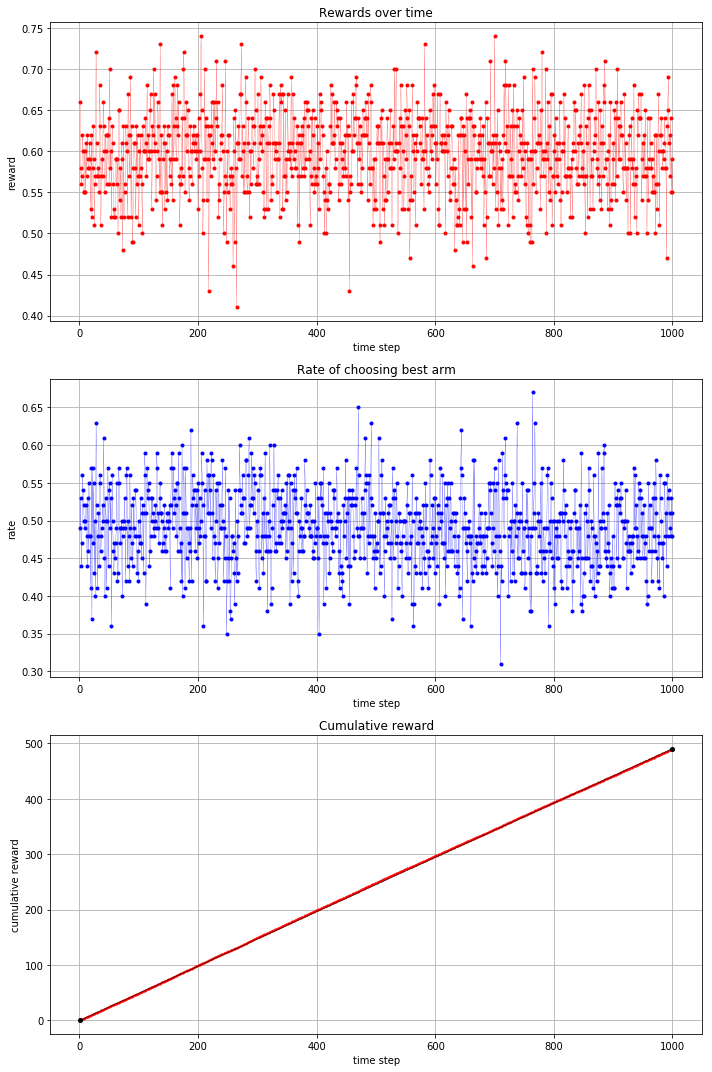

In [66]:
params = {"lr": 0.05}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)
#it [ H preferences ] [ softmax probs ]  sel.action last.action last.reward r_diff 

In [37]:
1+1*(5==5)

2

In [26]:
def greedyAction(q_estimate):
    # Choose greedly one of the best actions
    return randomArgmax(q_estimate)

def epsilonGreedyAction(q_estimate, eps):
    # Greedy action with prob p=1-eps, random with prob eps=1-p
    if np.random.choice([True, False], p=[1-eps, eps]):
        # Greedy action
        return greedyAction(q_estimate)
    else:
        # Random action
        return np.random.choice(np.arange(len(q_estimate)))

def upperConfidenceBoundAction(q_estimate, c, iteration, act_count):
    # De Sutton:
    # "if action a was never chosen > a is a maximizing action"
    # NO quiero que las acciones jamas elegidas 'me pisen' acciones con
    # pesos fuertes por tener peso infinito al dividir por cero.
    uncertainty = np.sqrt(np.log(iteration)/np.maximum(1, act_count))
    # Con 'maximizing action' de Sutton, elijo su valor a partir del maximo de las
    # acciones ya elegidas.
    # ie: Las acciones no elegidas tienen EL MISMO valor que LA MEJOR accion elegida hasta el momento,
    #     de esa forma evito que solo elija acciones NO tomadas hasta que las tome todas.
    # 1. q_estimate + uncertainty para acciones ya elegidas (ignoro las NO elegidas)
    part_candidates = q_estimate + c*np.where(act_count>0, uncertainty, 0)
    # 2. le doy el max puntaje (de q_estimate) a las acciones NO elegidas
    candidates = np.where(act_count>0, part_candidates, np.amax(part_candidates))
    return randomArgmax(candidates)

def gradientAction():
    pass

In [27]:
def randomArgmax(v):
    """Like np.argmax(), but if there are several "best" actions,
       chooses and returns one randomly"""
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

## Gradient Bandits

Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [14]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # función que realiza las simulaciones de los agentes. Se define el número de repeticiones que seran
    #  promediadas y el número de pasos N. agents es una lista de agentes.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

### up

In [15]:
def plot_results(agents, actions, rewards):
    # Simulates and plot data
    # Number of steps to play
    N = 1000
    # We play for 'N' steps, then repeat for 'reps' times, and take the mean
    reps = 100
    # Generating data
    total_data = np.asarray(simulateBandits(agents, narms=actions, initp=rewards, initq=None, repetitions=reps, N=N))
    # data shape: (rewards, agents, time step)
    if len(agents)==1:
        # reshaping as several actor data
        total_data = total_data.reshape(2,1,N)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    # Subplot 1: Rewards over time
    ax1.set_title("Rewards over time")
    ax1.set_xlabel("time step")
    ax1.set_ylabel("reward")
    ax1.grid()
    # Subplot 2: Agent's rate of choosing best arm
    ax2.set_title("Rate of choosing best arm")
    ax2.set_xlabel("time step")
    ax2.set_ylabel("rate")
    ax2.grid()
    # Subplot 3: Cumulative reward
    ax3.set_title("Cumulative reward")
    ax3.set_xlabel("time step")
    ax3.set_ylabel("cumulative reward")
    ax3.grid()
    time_steps = np.arange(1, N+1)
    # looping over individual agent data
    for a in range(total_data.shape[-2]):
        # data from each agent
        data = total_data[:,a,:]
        # Subplot 1: Rewards over time
        ax1.plot(time_steps, data[0,:], 'r.-', label="reward-actor-"+str(a), linewidth=0.2)
        # Subplot 2: Agent's rate of choosing best arm
        ax2.plot(time_steps, data[1,:], 'b.-', label="best-arm-actor-"+str(a), linewidth=0.2)
        # Subplot 3: Cumulative reward
        ax3.plot(time_steps, np.cumsum(data[1,:]), 'r.', label="cumulative-actor-"+str(a), markersize=2, linewidth=0.5)
        # straight line for comparison
        ax3.plot([time_steps[0], time_steps[-1]],
                 [np.cumsum(data[1,:])[0], np.cumsum(data[1,:])[-1]],
                 'ko-', label="straight-line-"+str(a), markersize=4, linewidth=0.5)
    plt.tight_layout()
    plt.show()

[go down](#down)

# Ejercicios:

1) Completar pertinentemente el código donde diga "COMPLETAR".

[2)](#Bandits-de-2-brazos) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[3)](#Bandits-de-10-brazos) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

4) Estudie la dependencia del hiperparametro epsilon en la regla de decisión epsilon-greedy.


## Bandits de 2 brazos

### Greedy

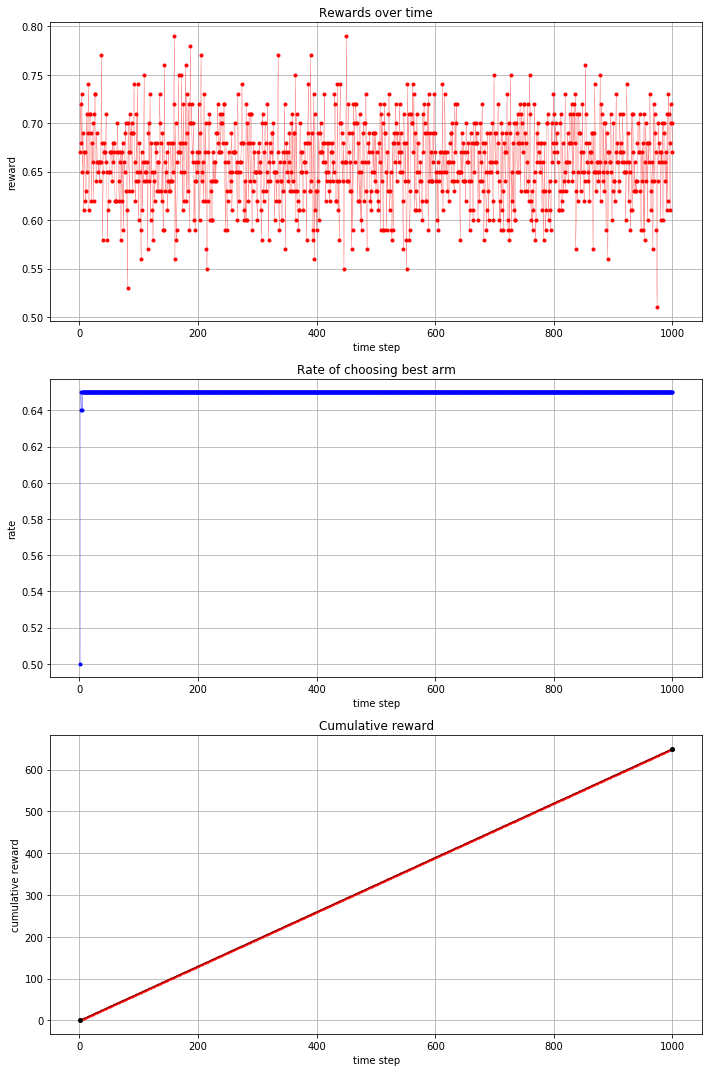

In [16]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

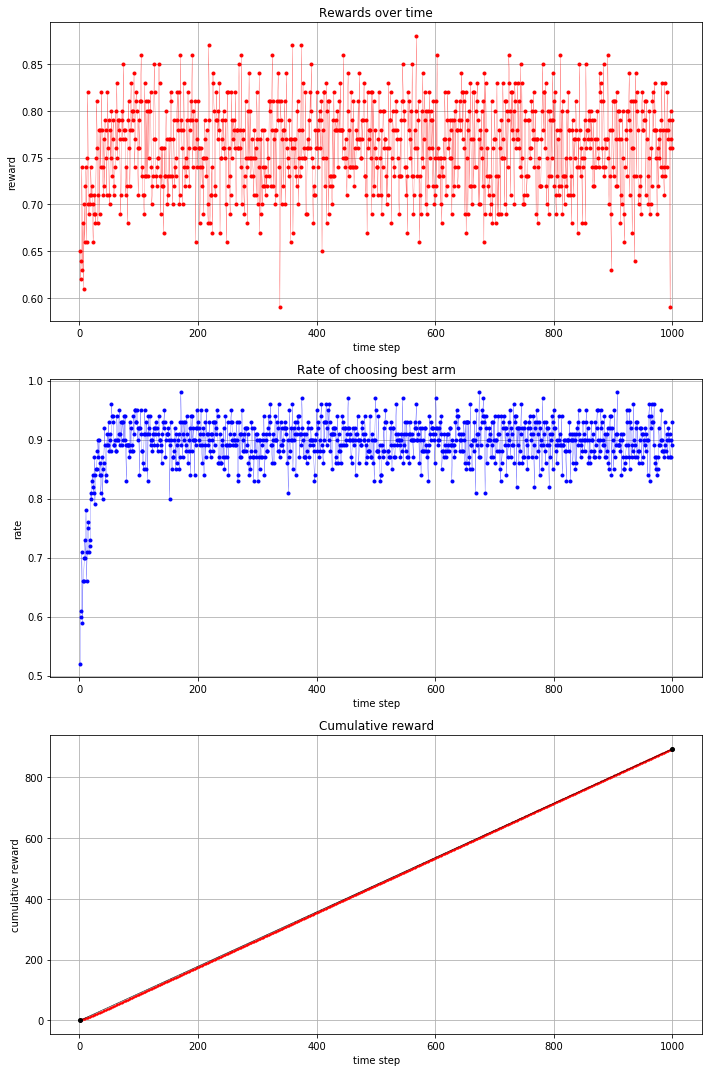

In [17]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

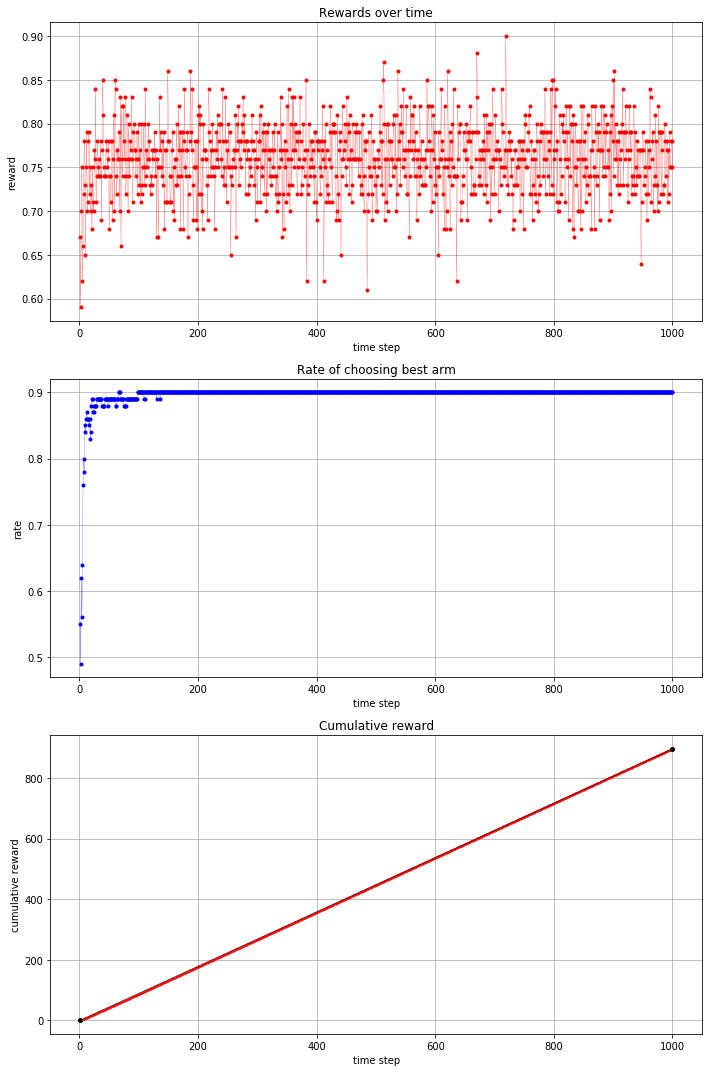

In [18]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

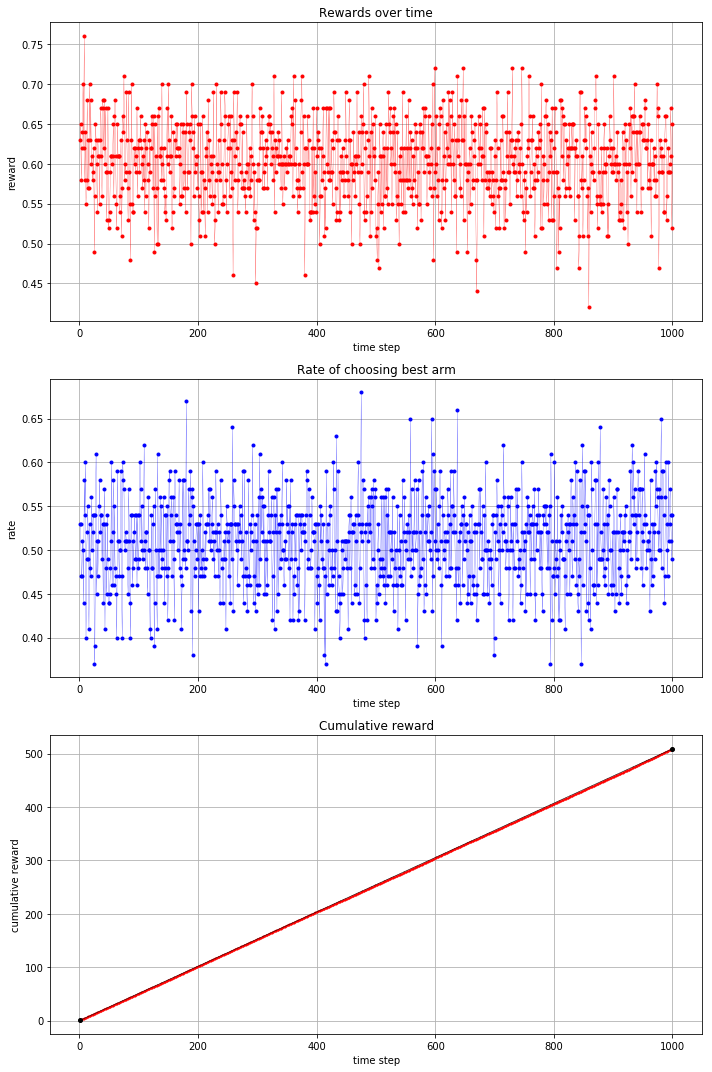

In [51]:
params = {"lr": 0.05}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Bandits de 10 brazos

#### Greedy

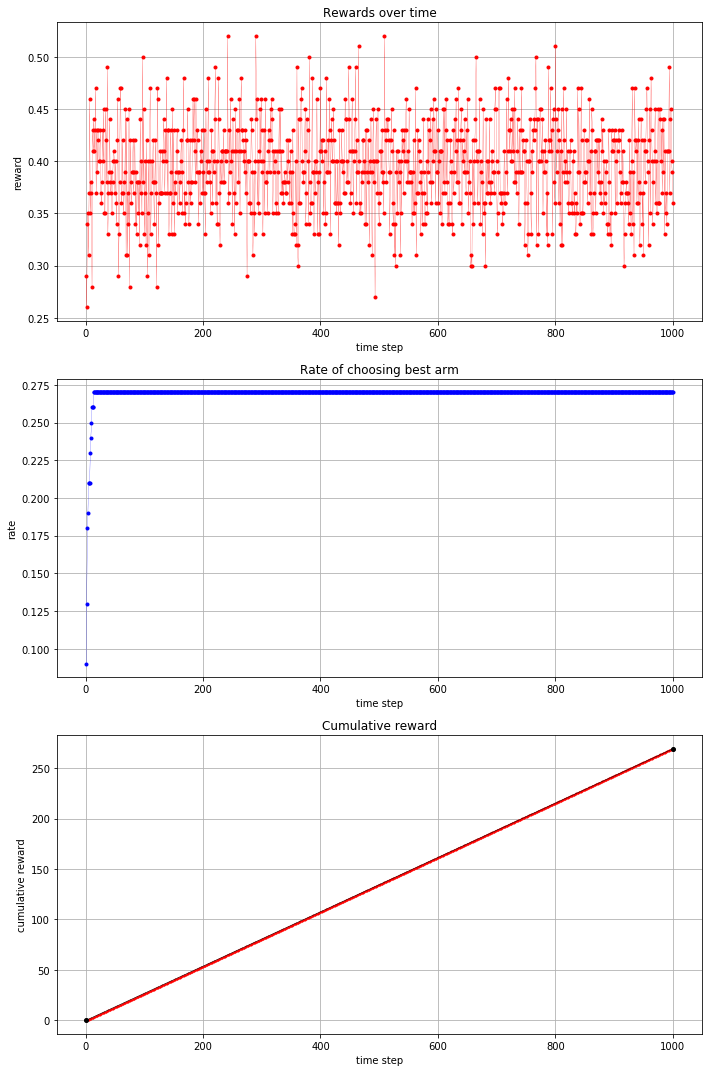

In [20]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

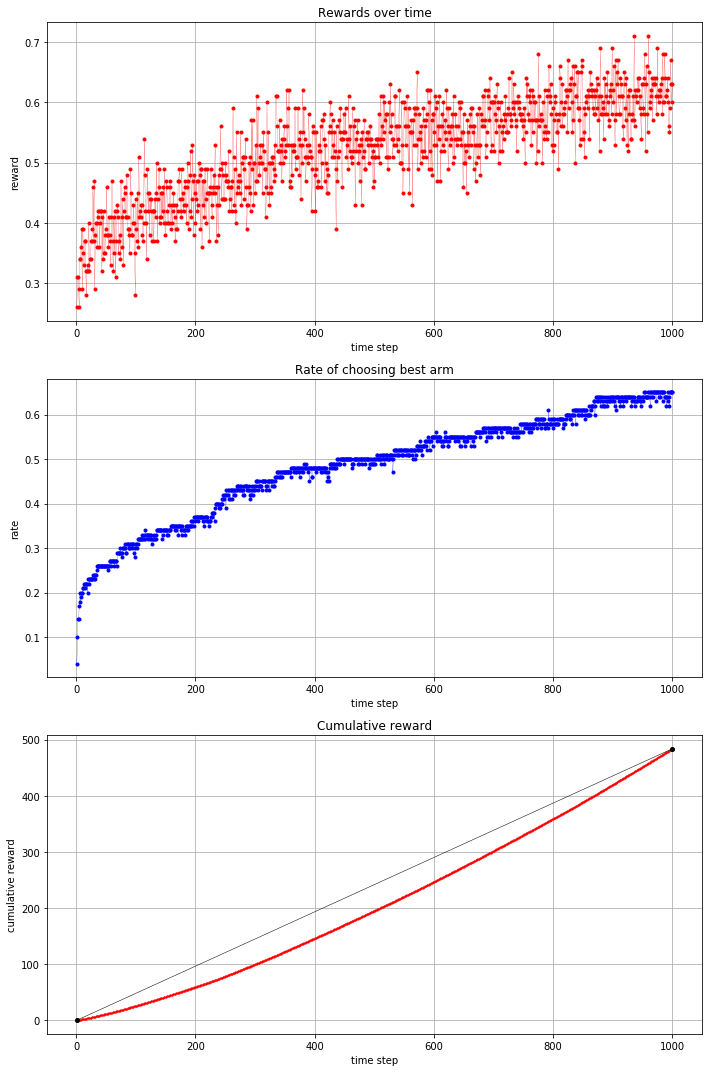

In [450]:
params = {"epsilon": 0.01}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

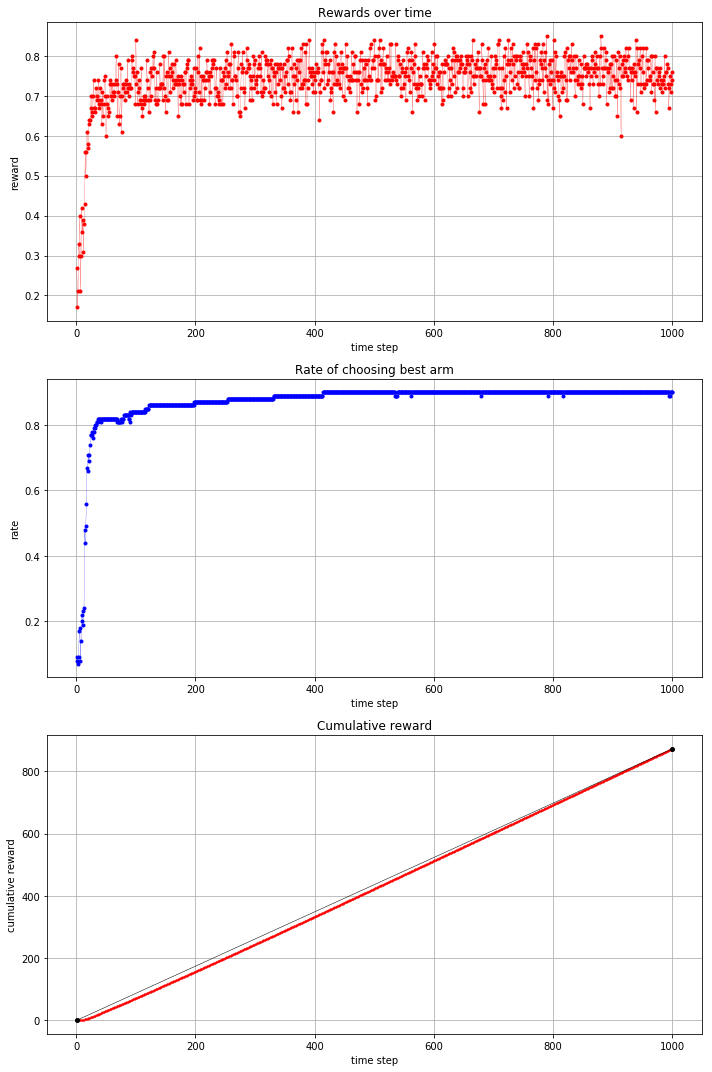

In [451]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 0 6 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 0 0 0.0
102 [ 0.01339882 -0.00895896 -0.01384925 -0.00112883  0.00356213  0.01135956
 -0.00512049 -0.00180318 -0.00296771  0.0055079 ] [0.10134554 0.09910482 0.09862135 0.09988387 0.10035352 0.10113908
 0.09948596 0.09981653 0.09970036 0.10054897] 8 0 0 -0.23076923076923075
103 [ 0.01363728 -0.00872577 -0.0136172  -0.00089381  0.00379825  0.01159754
 -0.0048864  -0.00156832 -0.00508606  0.00574448] [0.10136961 0.09912783 0.09864414 0.09990725 0.10037712 0.10116305
 0.09950915 0.09983988 0.09948929 0.10057267] 8 8 0 -0.23529411764705888
104 [ 0.01290517 -0.00944169 -0.01432963 -0.00161537  0.00307331  0.01086692
 -0.00560508 -0.00228938  0.00141763  0.00501813] [0.10129556 0.09905703 0.09857403 0.09983532 0.10030452 0.10108931
 0.0994378  0.

102 [-0.0008632   0.00536526  0.02269866 -0.00585077 -0.02390014  0.00288169
  0.00195937  0.01606406 -0.0014551  -0.01689983] [0.09990519 0.10052939 0.10228709 0.09940815 0.09762999 0.10028002
 0.10018758 0.1016107  0.09984607 0.09831582] 1 4 0 -0.375
103 [-0.00161248  0.01211129  0.02193151 -0.00659633 -0.02463236  0.00212959
  0.00120797  0.01530198 -0.00220395 -0.0176372 ] [0.09982972 0.10120921 0.102208   0.09933342 0.0975579  0.10020399
 0.10011168 0.10153265 0.09977069 0.09824273] 5 1 1 0.75
104 [-0.00147938  0.01224623  0.02206779 -0.00646388 -0.02450229  0.00092986
  0.00134145  0.01543735 -0.00207092 -0.01750621] [0.09984303 0.10122288 0.10222195 0.0993466  0.09757061 0.10008386
 0.10012506 0.10154641 0.09978398 0.09825561] 1 5 0 -0.13333333333333336
202 [-0.00720026  0.01125138  0.02514959 -0.02050447 -0.0285009   0.00855221
 -0.00221328  0.03084996  0.00316153 -0.02054575] [0.09926515 0.10111376 0.10252887 0.09795325 0.0971731  0.1008412
 0.09976142 0.10311499 0.10029906 0.

202 [ 0.00333831 -0.03141766 -0.00680239 -0.00271458  0.0146567  -0.00849834
 -0.00271458  0.01362131  0.00154542  0.01898581] [0.10032492 0.09689793 0.09931269 0.09971949 0.10146688 0.09914441
 0.09971949 0.10136188 0.10014521 0.1019071 ] 4 1 0 -0.08695652173913042
203 [ 0.00343386 -0.03132538 -0.00670781 -0.00261961  0.01380095 -0.00840392
 -0.00261961  0.01371785  0.0016408   0.01908287] [0.10033464 0.096907   0.09932222 0.0997291  0.10138023 0.0991539
 0.0997291  0.1013718  0.10015489 0.10191712] 6 4 0 -0.09523809523809523
204 [ 0.00252173 -0.03220635 -0.00761073 -0.00352624  0.01287931 -0.00930531
  0.00556467  0.01279628  0.0007303   0.01815635] [0.10024305 0.09682156 0.09923247 0.09963861 0.10128672 0.09906446
 0.10054855 0.10127831 0.10006363 0.10182263] 5 6 1 0.9090909090909091
302 [ 0.03223695 -0.02492035 -0.02593524  0.00057603  0.01524898 -0.00588796
  0.01360595  0.01080623 -0.02690158  0.01117098] [0.10325687 0.09752049 0.09742156 0.10003888 0.10151756 0.09939431
 0.10135

302 [-0.0216702  -0.01145076  0.00794208  0.00222245 -0.01017309 -0.00964211
  0.02686399 -0.00213353  0.00960743  0.00843374] [0.09784769 0.09885277 0.10078851 0.10021369 0.09897915 0.09903172
 0.10271378 0.09977811 0.1009565  0.10083808] 9 5 0 -0.11764705882352944
303 [-0.02137369 -0.0111512   0.0082475   0.00252612 -0.00987316 -0.00934202
  0.02717525 -0.00183117  0.00991336  0.00570901] [0.09787691 0.09888259 0.10081951 0.10024433 0.09900905 0.09906165
 0.10274597 0.09980849 0.1009876  0.1005639 ] 3 9 0 -0.30303030303030304
304 [-0.02220746 -0.01199354  0.00738867  0.01019071 -0.01071657 -0.01018587
  0.0263     -0.00268139  0.0090531   0.00485235] [0.09779483 0.09879882 0.10073243 0.10101509 0.09892506 0.09897757
 0.10265555 0.09972314 0.10090024 0.10047727] 4 3 1 0.8518518518518519
402 [-0.03421514 -0.01137135  0.01238219  0.03458718 -0.00796645 -0.00084136
  0.02140969 -0.00562925 -0.01099315  0.00263764] [0.09662025 0.09885282 0.10122904 0.10350197 0.09918998 0.09989924
 0.1021

302 [-0.00369426  0.01906389  0.02587198 -0.00230405  0.03918483  0.02145086
 -0.03802097 -0.02822776 -0.00257178 -0.03075274] [0.09960019 0.10189289 0.10258896 0.09973875 0.10396384 0.1021364
 0.09623926 0.09718638 0.09971205 0.09694129] 6 2 1 0.6363636363636362
303 [-0.00350751  0.01925494  0.02606433 -0.00211704  0.03937977  0.02164237
 -0.03971552 -0.02804553 -0.00238482 -0.03057098] [0.09961806 0.10191162 0.10260794 0.09975667 0.10398335 0.10215521
 0.09607561 0.09720338 0.09972996 0.0969582 ] 0 6 0 -0.18750000000000006
304 [-0.00742222  0.01969803  0.02651045 -0.00168332  0.03983187  0.02208652
 -0.0392978  -0.02762291 -0.00195121 -0.03014942] [0.09922857 0.1019565  0.10265344 0.09979967 0.10403008 0.10220031
 0.09611548 0.0972442  0.09977294 0.09699882] 3 0 0 -0.4347826086956521
402 [-0.0396525   0.01786541  0.02772528  0.00097238  0.06054148  0.00613915
 -0.04189546  0.00016456  0.00113458 -0.03299487] [0.09606797 0.1017556  0.10276386 0.10005108 0.10619212 0.10056936
 0.095852

502 [-0.03247518 -0.00485198  0.02848786  0.03809769  0.03994132  0.00037791
 -0.06225624 -0.02676991  0.03681522 -0.01736668] [0.0967507  0.09946052 0.10283241 0.10382538 0.10401697 0.09998205
 0.09391184 0.09730427 0.10369231 0.09822356] 3 6 0 -0.24999999999999994
503 [-0.03325264 -0.00565122  0.02766153  0.04529909  0.03910547 -0.00042551
 -0.06301089 -0.02755182  0.03598197 -0.01815598] [0.09667233 0.09937779 0.1027441  0.10457233 0.10392665 0.09989847
 0.09383792 0.09722502 0.10360254 0.09814284] 8 3 1 0.8035714285714286
504 [-0.03308848 -0.00548246  0.027836    0.04547667  0.03928195 -0.00025587
 -0.06285154 -0.02738672  0.03445979 -0.01798932] [0.09668876 0.09939514 0.10276262 0.10459151 0.10394559 0.099916
 0.09385341 0.09724164 0.10344556 0.09815976] 8 8 0 -0.16981132075471697
602 [-0.03395585  0.003017    0.04057878  0.06823782  0.03469127  0.00409008
 -0.05923311 -0.04131005  0.02411666 -0.04023261] [0.09658355 0.10022136 0.10405744 0.10697575 0.10344661 0.10032896
 0.094172

802 [-0.06113954 -0.01621132  0.01575218 -0.04456409  0.0333433   0.06510978
  0.02650107 -0.01027988  0.04626011 -0.05477161] [0.09398686 0.09830582 0.10149877 0.09555772 0.10330005 0.1066342
 0.10259566 0.09889065 0.10464301 0.09458727] 3 4 0 -0.22093023255813962
803 [-0.06094051 -0.01600315  0.01596712 -0.04647938  0.03356205  0.06533559
  0.02671833 -0.01007046  0.0464817  -0.05457131] [0.09400463 0.0983253  0.10151958 0.09537392 0.10332162 0.10665722
 0.10261693 0.09891037 0.10466516 0.09460528] 0 3 0 -0.21176470588235305
804 [-0.06286816 -0.01579394  0.01618312 -0.04627645  0.03378189  0.06556252
  0.02693667 -0.00986002  0.0467044  -0.05437002] [0.09382235 0.09834457 0.10154016 0.09539201 0.10334295 0.10668001
 0.10263797 0.09892987 0.10468707 0.09462306] 4 0 0 -0.2127659574468085
902 [-0.04367251 -0.00442248  0.00946622 -0.05016453  0.04510729  0.06703426
  0.03092034 -0.02966457  0.03354683 -0.05815084] [0.09564344 0.0994721  0.10086328 0.09502454 0.10452298 0.10684017
 0.1030

902 [ 0.04906285 -0.02185021  0.04930878  0.02504172 -0.00566377  0.00994698
 -0.06573972 -0.06211817 -0.01918082  0.04119236] [0.10494336 0.09775924 0.10496918 0.10245254 0.09935449 0.10091766
 0.09356143 0.09390088 0.09802055 0.10412065] 5 8 0 -0.1744186046511628
903 [ 0.04925064 -0.02167527  0.04949662  0.02522506 -0.00548598  0.00833809
 -0.06557229 -0.06195014 -0.01900541  0.04137868] [0.1049632  0.09777647 0.10498902 0.10247145 0.09937228 0.10075555
 0.09357721 0.09391678 0.09803786 0.10414018] 4 5 0 -0.1789473684210526
904 [ 0.04948493 -0.02145702  0.04973097  0.02545379 -0.00749631  0.00856299
 -0.06536342 -0.0617405  -0.01878658  0.04161113] [0.10498759 0.09779761 0.10501342 0.10249469 0.09917251 0.10077801
 0.09359657 0.09393628 0.09805913 0.10416418] 2 4 0 -0.2232142857142858
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 4 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

802 [-0.0557332  -0.00978495  0.05543774 -0.01368296  0.02321243  0.03280729
 -0.00327998  0.02065759  0.02163466 -0.07126863] [0.09451315 0.09895718 0.10562656 0.09857219 0.10227697 0.10326303
 0.09960299 0.10201601 0.10211573 0.09305619] 6 5 0 -0.2
803 [-0.05552982 -0.009572    0.05566504 -0.01347084  0.02343252  0.0330295
 -0.00521754  0.02087712  0.02185441 -0.07106838] [0.09453224 0.09897812 0.10565043 0.09859297 0.10229935 0.10328584
 0.09941005 0.10203827 0.10213804 0.0930747 ] 4 6 0 -0.21518987341772156
804 [-0.05530203 -0.0093335   0.05591962 -0.01323327  0.02126939  0.03327838
 -0.004978    0.021123    0.02210052 -0.07084411] [0.09455425 0.09900221 0.10567785 0.09861688 0.1020788  0.10331206
 0.09943436 0.10206386 0.10216368 0.09309604] 5 4 0 -0.2409638554216868
902 [-0.06235    -0.00934176  0.05621001  0.00095101  0.00767738  0.02383906
 -0.02200654  0.03157107  0.0451982  -0.07174844] [0.09387872 0.09898932 0.10569565 0.10001345 0.10068845 0.10232896
 0.09774355 0.10312324 

902 [-0.06435278  0.06431127  0.01408832  0.02178499  0.01694188 -0.01317302
  0.00839686 -0.0465399  -0.0179044   0.01644678] [0.09371019 0.10657735 0.10135691 0.10214003 0.10164655 0.09863111
 0.10078168 0.0953944  0.09816555 0.10159624] 7 9 0 -0.11702127659574468
903 [-0.06452512  0.06411527  0.01390192  0.02159715  0.01675494 -0.01335441
  0.00821152 -0.04487626 -0.01808493  0.01625994] [0.09369484 0.10655737 0.10133888 0.10212172 0.10162842 0.09861406
 0.10076386 0.09555405 0.09814867 0.10157813] 7 7 1 0.18390804597701138
904 [-0.06469548  0.06392153  0.01371766  0.02141147  0.01657016 -0.01353371
  0.00802831 -0.04323181 -0.01826338  0.01607525] [0.09367965 0.1065376  0.10132104 0.10210359 0.10161047 0.09859719
 0.10074623 0.09571209 0.09813195 0.1015602 ] 8 7 1 0.18181818181818166
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 8 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

102 [ 0.00800586  0.01150376 -0.01015443  0.01729671  0.00582151 -0.00677777
 -0.00576942 -0.01398761 -0.00964409  0.00370548] [0.10079868 0.10115188 0.09898467 0.10173955 0.10057874 0.09931947
 0.09941967 0.09860597 0.0990352  0.10036614] 9 2 0 -0.14285714285714288
103 [ 0.00724987  0.01074512 -0.01089681  0.01653366  0.00506717 -0.00752267
 -0.00651507 -0.01472716 -0.01038685  0.01045273] [0.10072199 0.10107465 0.0989107  0.10166142 0.10050238 0.099245
 0.09934505 0.09853256 0.09896115 0.1010451 ] 8 9 1 0.75
104 [ 0.00664554  0.01013867 -0.01149028  0.01592369  0.00446416 -0.00811814
 -0.00711114 -0.01531835 -0.00498062  0.00984646] [0.10066161 0.10101385 0.09885248 0.10159991 0.10044226 0.09918639
 0.09928632 0.09847479 0.09949807 0.10098433] 4 8 1 0.6
202 [ 0.00116423  0.01583067  0.0030357   0.01434116  0.01516719 -0.02566989
 -0.01747423  0.00160349 -0.01554284  0.00754451] [0.10010669 0.10158572 0.10029422 0.10143452 0.10151834 0.09745614
 0.09825814 0.10015068 0.0984481  0.1007

102 [-0.00076602 -0.00493357 -0.01410359  0.00189526  0.00442862  0.00425455
 -0.0119087  -0.00020747  0.00344445  0.01789647] [0.09991973 0.09950418 0.09859589 0.100186   0.10044013 0.10042265
 0.09881254 0.09997556 0.10034133 0.10180199] 9 8 0 -0.5714285714285714
103 [-5.99484999e-04 -4.76772954e-03 -1.39392672e-02  2.06224051e-03
  4.59602326e-03  4.42191628e-03 -1.17440153e-02 -4.08472048e-05
  3.61168678e-03  1.63994774e-02] [0.09993666 0.09952097 0.09861238 0.10020302 0.10045723 0.10043974
 0.0988291  0.0999925  0.1003584  0.10165   ] 5 9 0 -0.16666666666666666
104 [-0.00134901 -0.00551414 -0.01467886  0.00131072  0.00384259  0.01116862
 -0.01248523 -0.00079079  0.002859    0.0156371 ] [0.0998612  0.09944614 0.0985389  0.10012716 0.10038099 0.10111909
 0.0987553  0.09991696 0.10028231 0.10157195] 6 5 1 0.75
202 [ 0.01555103 -0.02754924 -0.0059945   0.00790125  0.00073122  0.000436
 -0.00903687  0.00483233 -0.00459137  0.01772013] [0.10155946 0.09727521 0.09939471 0.10078551 0.100

202 [ 0.00107209 -0.01799122 -0.03257083  0.01215931  0.03532375  0.01773365
  0.00107209  0.00616942  0.00023236 -0.02320061] [0.10008888 0.09819893 0.09677761 0.10120477 0.10357648 0.10177049
 0.10008888 0.10060037 0.10000487 0.0976887 ] 7 4 1 0.7692307692307692
203 [ 8.61372300e-04 -1.81979562e-02 -3.27745697e-02  1.19462450e-02
  3.51056933e-02  1.75193944e-02  8.61372300e-04  8.06289525e-03
  2.18277847e-05 -2.34062746e-02] [0.10006766 0.0981785  0.09675776 0.10118307 0.10355375 0.10174855
 0.10006766 0.1007909  0.09998368 0.09766848] 8 7 1 0.21052631578947378
204 [ 0.00102815 -0.01803433 -0.03261331  0.01211488  0.03527828  0.01768898
  0.00102815  0.00823088 -0.0014782  -0.02324349] [0.10008433 0.09819454 0.09677335 0.10120011 0.10357161 0.10176578
 0.10008433 0.10080781 0.09983379 0.09768436] 0 8 0 -0.16666666666666663
302 [ 0.00819172 -0.00356158 -0.05540371  0.01331497  0.02126158  0.01203609
  0.03343804 -0.00070086 -0.00615916 -0.02241709] [0.10079461 0.09961688 0.09458411 

 -0.00697229  0.04965968  0.03641138 -0.00336864] [0.09737149 0.09542188 0.09967676 0.09608748 0.10446215 0.09942061
 0.09925433 0.10503751 0.10365512 0.09961266] 5 5 0 -0.17857142857142855
402 [-0.0215361  -0.04690587 -0.00375354 -0.03966245  0.0160767  -0.00782104
  0.00914471  0.04953295  0.02841191  0.01651273] [0.09782939 0.0953787  0.09958461 0.09607208 0.10157911 0.09918037
 0.1008774  0.10503505 0.10283987 0.10162341] 4 8 0 -0.10638297872340428
403 [-0.02124525 -0.04662232 -0.00345748 -0.03937683  0.01340572 -0.00752618
  0.00944462  0.04984521  0.02871765  0.01681486] [0.09785825 0.09540614 0.0996145  0.09609991 0.10130856 0.09921002
 0.10090807 0.10506828 0.10287173 0.10165453] 2 4 0 -0.2972972972972972
404 [-0.02093497 -0.04631981 -0.00631236 -0.03907212  0.01372694 -0.00721161
  0.00976457  0.05017836  0.02904383  0.01713718] [0.09788843 0.09543482 0.09933033 0.09612901 0.10134092 0.09924105
 0.10094016 0.10510309 0.10290509 0.1016871 ] 7 2 0 -0.3170731707317073
502 [-0.027

402 [ 0.01905414 -0.02312529  0.01337969 -0.00163363 -0.0454588   0.01116562
 -0.03022326  0.0303943   0.01028985  0.01615738] [0.10189594 0.09768741 0.10131937 0.09980959 0.09552989 0.10109529
 0.09699648 0.10305803 0.1010068  0.1016012 ] 4 3 0 -0.20000000000000007
403 [ 0.01918422 -0.02300058  0.01350903 -0.00150621 -0.04661344  0.01129468
 -0.03009944  0.03052587  0.0104188   0.01628709] [0.1019086  0.09769902 0.10133189 0.09982173 0.09541909 0.10110775
 0.09700792 0.10307099 0.10101923 0.10161378] 1 4 0 -0.12765957446808512
404 [ 0.01937702 -0.02470764  0.01370074 -0.00131736 -0.04643292  0.01148596
 -0.02991591  0.03072087  0.01060991  0.01647933] [0.10192778 0.09753193 0.10135085 0.09984012 0.09543588 0.10112663
 0.09702528 0.10309061 0.10103807 0.10163285] 4 1 0 -0.1891891891891892
502 [ 0.00273953 -0.00500466  0.00990941  0.00479748 -0.04254251  0.0051368
 -0.04051589  0.03620094  0.0232638   0.00601507] [0.1002468  0.09947347 0.10096814 0.10045331 0.09580866 0.1004874
 0.09600

 0.09759746 0.09788159 0.0964285  0.10313922] 2 0 0 -0.29729729729729726
502 [ 0.02204381 -0.04765619  0.02400908  0.01780551  0.02150732  0.02180572
 -0.0212289  -0.03043509 -0.03306655  0.02521529] [0.10218973 0.09530967 0.10239076 0.10175754 0.10213492 0.10216541
 0.09786202 0.09696522 0.09671039 0.10251434] 5 5 1 0.8103448275862069
503 [ 0.02223433 -0.04747849  0.02419998  0.01799523  0.02169774  0.02013179
 -0.02104645 -0.0302543  -0.03288624  0.02540641] [0.10220959 0.09532696 0.10241069 0.10177723 0.10215476 0.10199491
 0.09788024 0.09698311 0.09672819 0.10253432] 4 5 0 -0.18644067796610175
504 [ 0.02238035 -0.04734231  0.02434628  0.01814063  0.0204151   0.0202775
 -0.02090662 -0.03011576 -0.03274806  0.02555289] [0.10222481 0.09534022 0.10242597 0.10179232 0.10202411 0.10201007
 0.09789421 0.09699683 0.09674184 0.10254963] 1 4 0 -0.14285714285714288
602 [ 0.04639649 -0.06785183  0.02855793  0.01975082  0.02989543  0.01112371
 -0.03707145 -0.02417001 -0.01847442  0.01184333] [0

602 [ 0.03165835  0.00876053  0.0400531   0.02621838  0.01644051  0.01595906
 -0.01379937 -0.01236392 -0.04725684 -0.06566979] [0.10316131 0.10082598 0.10403096 0.10260163 0.1016033  0.10155439
 0.09857682 0.09871842 0.09533325 0.09359394] 6 0 0 -0.25423728813559326
603 [ 0.0308524   0.00797283  0.03924035  0.0254168   0.01564674  0.01516566
 -0.006757   -0.01313516 -0.04800163 -0.066401  ] [0.10307915 0.10074751 0.10394741 0.10252037 0.10152362 0.10147479
 0.0992744  0.09864322 0.09526315 0.0935264 ] 5 6 1 0.7812499999999999
604 [ 0.03100273  0.00811975  0.03939194  0.02556631  0.01579479  0.01385531
 -0.00661223 -0.01299131 -0.0478627  -0.0662646 ] [0.10309484 0.10076251 0.10396336 0.10253589 0.10153884 0.1013421
 0.09928896 0.0986576  0.09527657 0.09353933] 2 5 0 -0.14583333333333337
702 [ 7.49839546e-03  2.13876226e-05  5.53157095e-02  2.53758293e-02
  3.15370972e-02  1.88058027e-02 -1.17812728e-02 -4.52195290e-03
 -4.72567472e-02 -7.49942490e-02] [0.10068707 0.09993704 0.10561863 

502 [ 0.02016018 -0.06496943 -0.02485201 -0.00687109  0.0150358   0.06917561
 -0.00591307  0.00016437  0.01298497 -0.01491532] [0.10198166 0.09365927 0.09749302 0.09926189 0.1014604  0.10710487
 0.09935703 0.09996271 0.10125254 0.09846661] 6 7 1 0.14814814814814825
503 [ 0.02032706 -0.06481617 -0.02469247 -0.00670867  0.01520183  0.06935087
 -0.00738685  0.00032794  0.01315065 -0.0147542 ] [0.10199854 0.0936735  0.09750845 0.09927788 0.10147711 0.1071235
 0.09921058 0.09997892 0.10126918 0.09848234] 8 6 0 -0.16363636363636366
504 [ 0.02048398 -0.06467206 -0.02454246 -0.00655593  0.01535795  0.06951568
 -0.00723422  0.00048176  0.01176799 -0.01460269] [0.10201472 0.09368715 0.09752324 0.09929321 0.10149313 0.10714133
 0.09922589 0.09999447 0.10112943 0.09849743] 8 8 0 -0.15384615384615385
602 [-0.00398267 -0.07757942 -0.01376003  0.00895314  0.03154664  0.06512476
  0.00380108 -0.00028276 -0.00426239 -0.00955835] [0.09954472 0.09248164 0.09857617 0.10084077 0.10314505 0.10666727
 0.1003

702 [-0.06603271 -0.01632501  0.00199441  0.01252343  0.05199428 -0.09518947
  0.00707424  0.05124365  0.03758329  0.01513387] [0.09351368 0.0982795  0.10009651 0.101156   0.10522856 0.09082649
 0.10060628 0.1051496  0.10372298 0.1014204 ] 0 7 1 0.21739130434782594
703 [-0.06808741 -0.01610224  0.0022213   0.01275272  0.0522328  -0.09498359
  0.00730228  0.05148199  0.0378184   0.01536375] [0.0933203  0.09829988 0.10011769 0.10117764 0.10525204 0.09084379
 0.10062768 0.10517305 0.10374578 0.10144216] 0 0 0 -0.2266666666666666
704 [-0.07011551 -0.01588236  0.00244524  0.01297904  0.05246823 -0.09478039
  0.00752737  0.05171725  0.03805046  0.01559067] [0.09312977 0.09831996 0.10013855 0.10119896 0.10527518 0.09086084
 0.10064876 0.10519615 0.10376824 0.1014636 ] 5 0 0 -0.22368421052631574
802 [-0.06891596  0.0066036   0.00695781  0.00166503  0.05816367 -0.09125687
  0.00563069  0.04768657  0.026486    0.00697947] [0.09325022 0.10056517 0.1006008  0.10006974 0.10588632 0.09119002
 0.1004

902 [ 0.01061049 -0.00663181  0.04938944 -0.06161594 -0.03333543  0.04398043
  0.01328474  0.04714814 -0.04527045 -0.0175596 ] [0.10099509 0.09926863 0.10498851 0.09395778 0.09665288 0.10442216
 0.10126554 0.10475346 0.09550619 0.09818975] 9 4 0 -0.19230769230769232
903 [ 0.01080471 -0.00644091  0.04959134 -0.06143525 -0.03314956  0.04418124
  0.01347949  0.04734959 -0.04508678 -0.01929385] [0.10101432 0.0992872  0.1050093  0.09397439 0.09667047 0.10444272
 0.10128487 0.10477416 0.09552335 0.09801923] 9 9 0 -0.19230769230769235
904 [ 0.01099712 -0.00625179  0.04979135 -0.06125625 -0.03296543  0.04438018
  0.01367241  0.04754916 -0.04490483 -0.02101191] [0.10103333 0.09930556 0.10502986 0.09399082 0.09668787 0.10446306
 0.10130399 0.10479463 0.09554033 0.09785056] 8 9 0 -0.19047619047619052
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 7 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 7 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 

902 [ 0.04421433  0.02252996 -0.0347535  -0.01602747 -0.03183781  0.04341811
  0.01337599 -0.02206757 -0.00235731 -0.01649474] [0.10447989 0.1022387  0.09654669 0.09837166 0.09682861 0.10439673
 0.10130708 0.09777928 0.09972565 0.09832571] 0 0 0 -0.24999999999999997
903 [ 0.05085527  0.02177179 -0.03546946 -0.01675696 -0.03255586  0.04264394
  0.01262472 -0.02279267 -0.00309685 -0.0172239 ] [0.10517234 0.10215761 0.0964742  0.09829647 0.0967557  0.10431227
 0.10122743 0.09770497 0.09964842 0.09825058] 1 0 1 0.7415730337078652
904 [ 0.05107355  0.01990834 -0.03526923 -0.01655295 -0.03235505  0.04286043
  0.01283482 -0.02258989 -0.00289003 -0.01701998] [0.10519573 0.10196785 0.09649391 0.09831693 0.09677553 0.10433529
 0.10124912 0.09772518 0.09966944 0.09827102] 4 1 0 -0.20754716981132076
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 7 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 2 7 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

 -0.00986303 -0.04731348  0.00720111  0.00389963] [0.09778404 0.09526173 0.1061359  0.10008107 0.10019625 0.10525818
 0.09896147 0.09532386 0.10066465 0.10033286] 4 1 0 -0.1886792452830189
702 [-0.03906427 -0.04771663  0.06749793 -0.01010155  0.01514733  0.05974671
 -0.00301384 -0.05418059  0.02390629 -0.01222138] [0.09609202 0.09526418 0.10689729 0.0989158  0.10144511 0.10607191
 0.09961938 0.09465039 0.10233757 0.09870634] 2 1 0 -0.2028985507246377
703 [-0.03863117 -0.04728727  0.06347268 -0.00965573  0.01560455  0.06022478
 -0.00256486 -0.053754    0.02436753 -0.0117765 ] [0.09613647 0.0953079  0.106471   0.09896282 0.10149449 0.10612575
 0.09966705 0.09469356 0.10238779 0.09875317] 8 2 0 -0.45070422535211274
704 [-0.03936422 -0.048014    0.06266084 -0.01041032  0.01483065  0.05941557
 -0.00332482 -0.05447603  0.03121183 -0.0125295 ] [0.09606414 0.09523679 0.1063825  0.09888623 0.10141398 0.10603782
 0.09958937 0.09462335 0.10308894 0.09867689] 9 8 1 0.7625
802 [-0.02113374 -0.06392

902 [-0.00842129  0.05112785 -0.04563547 -0.00620803  0.05052111  0.00491563
  0.02411402 -0.03959719  0.02391307 -0.05472971] [0.09909654 0.1051769  0.09547652 0.09931611 0.1051131  0.10042704
 0.1023737  0.09605478 0.10235313 0.09461217] 0 0 0 -0.24038461538461536
903 [-0.0105663   0.05137827 -0.04540815 -0.00597156  0.05077137  0.00515474
  0.02435777 -0.03936848  0.02415677 -0.05450444] [0.09888394 0.10520296 0.09549797 0.09933933 0.10513913 0.10045078
 0.10239838 0.09607649 0.1023778  0.09463323] 0 0 0 -0.23809523809523808
904 [-0.01269158  0.05162639 -0.04518292 -0.00573727  0.05101934  0.00539165
  0.02459928 -0.03914189  0.02439823 -0.05428125] [0.09867369 0.10522873 0.09551918 0.09936229 0.10516487 0.10047426
 0.10242279 0.09609796 0.1024022  0.09465405] 9 0 0 -0.23584905660377356
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 0 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 

102 [ 0.01236728 -0.00179121 -0.01229296  0.00225858 -0.00300521  0.00826214
 -0.01385905 -0.00475959  0.00032032  0.01249971] [0.10124056 0.09981724 0.09877447 0.1002223  0.09969614 0.1008258
 0.0986199  0.09952139 0.10002823 0.10125396] 1 1 0 -0.14285714285714285
103 [ 0.01250226 -0.00299145 -0.01216126  0.00239221 -0.00287228  0.00839657
 -0.01372756 -0.0046269   0.00045369  0.01263472] [0.10125419 0.09969748 0.09878745 0.10023566 0.09970936 0.10083932
 0.09863284 0.09953456 0.10004154 0.1012676 ] 3 1 0 -0.13333333333333333
104 [ 0.01279156 -0.0027066  -0.01187901 -0.00017854 -0.0025874   0.00868469
 -0.01344575 -0.00434251  0.00073952  0.01292405] [0.10128352 0.09972591 0.09881536 0.09997834 0.0997378  0.10086841
 0.09866067 0.0995629  0.10007017 0.10129694] 3 3 0 -0.28571428571428575
202 [ 0.01315842  0.0223083  -0.00892975 -0.0173093   0.00086109  0.00499379
 -0.01887083  0.00182804 -0.00463289  0.00659313] [0.10131694 0.10224823 0.09910356 0.09827659 0.10007864 0.10049309
 0.098

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 9 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 5 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
102 [ 0.01700461 -0.00232898 -0.00010465  0.00616089 -0.02853211 -0.00553079
  0.0017106  -0.00618347  0.01028573  0.00751818] [0.10170801 0.09976051 0.09998266 0.10061107 0.09718043 0.09944161
 0.10016432 0.09937673 0.10102694 0.10074772] 0 8 0 -0.07692307692307693
103 [ 0.02149607 -0.00282779 -0.00060456  0.00565784 -0.02901802 -0.006028
  0.00120978 -0.00668036  0.0097806   0.00701444] [0.10216487 0.09970981 0.09993173 0.10055951 0.09713228 0.09939122
 0.10011321 0.09932641 0.10097495 0.10069602] 3 0 1 0.5
104 [ 0.02190473 -0.00242895 -0.00020484  0.00206008 -0.02862949 -0.00563044
  0.00161023 -0.00628305  0.0101845   0.00741723] [0.10220678 0.09974973 0.09997183 0.10019851 0.09717017 0.09943089
 0.10015345 0.09936602 0.10101588

102 [-0.01459523  0.01200465  0.0067651   0.00774353  0.0003079  -0.00412544
 -0.01479114  0.00127045 -0.00141316  0.00683334] [0.09854739 0.10120392 0.10067504 0.10077359 0.10002705 0.09958458
 0.09852809 0.10012338 0.09985505 0.10068191] 0 2 0 -0.18181818181818182
103 [-0.01699911  0.01227453  0.00703357  0.00801226  0.00057464 -0.00385988
 -0.0145284   0.00153745 -0.00114688  0.00710182] [0.09831037 0.10123081 0.10070165 0.10080025 0.10005332 0.09961061
 0.09855356 0.1001497  0.09988122 0.10070852] 8 0 0 -0.2666666666666667
104 [-0.01675333  0.0125276   0.00728532  0.00826426  0.00082477 -0.00361086
 -0.01428201  0.00178782 -0.00339717  0.00735359] [0.09833447 0.10125637 0.10072694 0.1008256  0.10007829 0.09963536
 0.09857779 0.10017471 0.09965665 0.10073382] 4 8 0 -0.25000000000000006
202 [-0.02661959  0.03538143  0.03102164  0.0132216  -0.00781616 -0.01057933
 -0.02346     0.01246144 -0.02003386 -0.00357716] [0.09735173 0.10357868 0.10312808 0.10130864 0.09919959 0.09892586
 0.097

302 [-0.02105496  0.01416637  0.03413299 -0.00326157  0.00283596 -0.00275457
 -0.0204477  -0.00273167 -0.04190355  0.04101869] [0.09788858 0.10139779 0.1034427  0.09964594 0.10025539 0.09969648
 0.09794805 0.09969876 0.09586887 0.10415744] 8 2 1 0.6551724137931034
303 [-0.0217703   0.01342539  0.03337706 -0.00398975  0.00210333 -0.00348312
 -0.02116347 -0.00346023 -0.03529644  0.04025754] [0.09782135 0.10132554 0.10336746 0.09957622 0.1001848  0.09962668
 0.09788073 0.09962896 0.09650711 0.10408113] 4 8 1 0.7307692307692307
304 [-0.0216691   0.01353021  0.03348399 -0.00388674  0.00117248 -0.00338006
 -0.02106221 -0.00335717 -0.0351966   0.04036521] [0.09783126 0.10133618 0.10337852 0.09958649 0.1000916  0.09963696
 0.09789065 0.09963924 0.09651676 0.10409235] 9 4 0 -0.10344827586206899
402 [-0.01092834  0.01031693  0.02275905 -0.0042062   0.02498299 -0.00762298
 -0.02235007  0.01047316 -0.04093669  0.01751214] [0.09889324 0.10101673 0.10228144 0.09956025 0.10250916 0.09922066
 0.097770

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 2 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 9 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 4 0 0.0
102 [ 0.01658056  0.00052059 -0.00762424  0.00052059  0.00306384 -0.01774868
 -0.0031699   0.00445936  0.00807444 -0.00467658] [0.10166794 0.1000482  0.09923663 0.1000482  0.10030297 0.09823698
 0.09967965 0.10044304 0.10080681 0.09952958] 4 6 0 -0.3076923076923077
103 [ 0.01668223  0.00062064 -0.007525    0.00062064  0.00216415 -0.01765045
 -0.00307022  0.0045598   0.00817525 -0.00457705] [0.1016783  0.10005823 0.0992465  0.10005823 0.10021279 0.09824666
 0.09968961 0.10045316 0.100817   0.09953951] 2 4 0 -0.10000000000000002
104 [ 0.01722452  0.00115429 -0.01232902  0.00115429  0.00269861 -0.01712646
 -0.00253854  0.00509555  0.00871294 -0.00404617] [0.10173291 0.10011111 0.09877034 0.10011111 0.10026583 0.09829763
 0.0997421  0.1

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 5 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 8 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 8 0 0.0
102 [ 0.01502591 -0.0257726  -0.01770785  0.00285492  0.00370969 -0.00781654
  0.00907869  0.00285492  0.00994682  0.00782604] [0.10150616 0.09744821 0.09823728 0.10027822 0.10036397 0.0992138
 0.10090428 0.10027822 0.10099191 0.10077796] 1 6 0 -0.1111111111111111
103 [ 0.01521047 -0.0274136  -0.01752924  0.00303725  0.00389217 -0.00763615
  0.00926215  0.00303725  0.01013044  0.00800927] [0.10152441 0.09728796 0.09825435 0.10029602 0.1003818  0.09923122
 0.1009223  0.10029602 0.10100997 0.10079594] 5 1 0 -0.18181818181818185
104 [ 0.01550054 -0.02713564 -0.01724851  0.00332381  0.00417897 -0.01020978
  0.0095505   0.00332381  0.01041904  0.00829726] [0.1015536  0.09731475 0.09828168 0.10032451 0.10041034 0.0989759
 0.10095115 0.100

502 [-0.0206665   0.00960718  0.01198392  0.02677681  0.01025062 -0.00668397
 -0.0007771  -0.02068118  0.00139248 -0.01120225] [0.09794434 0.10095481 0.10119504 0.10270314 0.10101979 0.09932347
 0.0999119  0.0979429  0.1001289  0.09887571] 5 4 1 0.85
503 [-0.02051286  0.00976554  0.01214266  0.02693791  0.01040908 -0.0080968
 -0.00062037 -0.02052755  0.00154954 -0.01104715] [0.09795927 0.10097068 0.10121099 0.10271956 0.10103568 0.09918312
 0.09992744 0.09795783 0.1001445  0.09889093] 6 5 0 -0.1568627450980392
504 [-0.02123467  0.00902155  0.01139689  0.02618103  0.00966461 -0.00882762
  0.00601174 -0.02124934  0.00081164 -0.01177582] [0.09788842 0.10089541 0.10113536 0.10264166 0.10096031 0.09911049
 0.10059219 0.09788698 0.10007046 0.09881872] 5 6 1 0.7368421052631579
602 [-0.02250698 -0.01288527  0.00247584  0.0381406   0.01712259  0.00199839
 -0.00085046 -0.00544086  0.0025125  -0.02056635] [0.09776025 0.09870541 0.10023334 0.10387265 0.10171224 0.1001855
 0.09990049 0.09944296 0.1

902 [ 0.06549414 -0.01833494 -0.05328414 -0.0328578   0.01120087  0.04859064
 -0.03136542  0.02793796  0.01908569 -0.03646701] [0.10669106 0.09811187 0.09474216 0.0966973  0.1010529  0.10490277
 0.09684172 0.10275846 0.10185283 0.09634893] 3 4 0 -0.15238095238095245
903 [ 0.0656989  -0.01814664 -0.05310231 -0.03459141  0.01139481  0.04879197
 -0.03117956  0.02813517  0.01928117 -0.03628209] [0.10671219 0.09812968 0.09475875 0.09652915 0.10107181 0.10492318
 0.09685906 0.10277803 0.10187205 0.09636609] 6 3 0 -0.19191919191919202
904 [ 0.06489333 -0.01888743 -0.05381765 -0.03532011  0.01063182  0.04799991
 -0.02436173  0.0273593   0.01851213 -0.03700956] [0.10662864 0.0980592  0.0946931  0.09646099 0.10099698 0.10484245
 0.09752386 0.10270061 0.10179601 0.09629816] 3 6 1 0.7549019607843136
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 2 5 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 2 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

202 [ 0.00242837 -0.00325769 -0.01073086  0.00076808  0.00656462  0.00242319
 -0.00071196  0.0066252   0.00326383 -0.00737278] [0.10024168 0.09967331 0.09893122 0.10007539 0.10065716 0.10024116
 0.09992738 0.10066326 0.10032546 0.09926399] 2 1 0 -0.18181818181818185
203 [ 0.00189767 -0.00378537 -0.00596049  0.00023827  0.00603173  0.0018925
 -0.00124099  0.00609227  0.0027327  -0.0078983 ] [0.10018894 0.09962117 0.09940472 0.10002282 0.10060398 0.10018842
 0.09987497 0.10061007 0.10027263 0.09921228] 8 2 1 0.5294117647058824
204 [ 0.00106277 -0.00461555 -0.00678887 -0.00059525  0.00519337  0.0010576
 -0.00207328  0.00525386  0.01023042 -0.00872507] [0.10010478 0.09953797 0.09932187 0.09993894 0.10051913 0.10010427
 0.09979134 0.10052521 0.10102673 0.09912975] 0 8 1 0.8333333333333333
302 [-0.01598239  0.00076474  0.0037093  -0.01197943  0.00844422  0.01334315
  0.01923781 -0.00199779  0.01472061 -0.03026022] [0.09840383 0.10006568 0.10036077 0.09879852 0.10083709 0.1013323
 0.10193138 

502 [ 0.02682556  0.00480172 -0.00684597 -0.00795752 -0.01476367 -0.00301529
  0.00921688 -0.00472621 -0.01837922  0.01484372] [0.10270987 0.10047254 0.09930905 0.09919873 0.09852586 0.0996902
 0.10091712 0.09951979 0.09817028 0.10148656] 4 3 0 -0.16363636363636364
503 [ 0.02699997  0.00497233 -0.00667733 -0.00778907 -0.01629448 -0.00284601
  0.00938825 -0.00455721 -0.01821252  0.01501606] [0.10272752 0.10048941 0.09932554 0.09921517 0.09837489 0.09970682
 0.10093415 0.09953634 0.09818638 0.10150379] 2 4 0 -0.16981132075471703
504 [ 0.02648633  0.00446989 -0.00217396 -0.00828514 -0.01678635 -0.00334454
  0.00888358 -0.00505489 -0.01870345  0.01450854] [0.10267501 0.10043917 0.09977408 0.0991662  0.09832674 0.09965735
 0.10088346 0.09948705 0.09813842 0.10145252] 9 2 1 0.5
602 [ 0.01243274 -0.00397058  0.01977751 -0.00215995 -0.0125621  -0.00887675
 -0.00845738  0.00991957  0.00425471 -0.01035775] [0.10124547 0.09959825 0.10199183 0.09977875 0.09874622 0.0991108
 0.09915237 0.10099134 0

602 [-0.04678642  0.02646959 -0.02731887  0.00869816  0.00806168  0.01931784
  0.02169206 -0.0230356   0.01565378 -0.00275221] [0.09540349 0.10265473 0.09727896 0.10084652 0.10078235 0.10192318
 0.10216546 0.09769652 0.10155041 0.09969837] 6 8 1 0.8709677419354839
603 [-0.04661174  0.02665755 -0.02714076  0.00888281  0.00824621  0.01950446
  0.02004814 -0.02285672  0.01583971 -0.00256967] [0.09542051 0.1026744  0.09729665 0.10086552 0.10080133 0.10194258
 0.10199802 0.09771436 0.10156967 0.09971695] 1 6 0 -0.1830985915492958
604 [-0.04649723  0.02558076 -0.027024    0.00900385  0.00836717  0.01962679
  0.02017053 -0.02273946  0.0159616  -0.00245001] [0.09543173 0.10256422 0.09730831 0.10087804 0.10081383 0.10195537
 0.10201082 0.09772612 0.10158237 0.09972919] 1 1 0 -0.12000000000000002
702 [-0.04085975  0.04030007 -0.05092306 -0.00904911  0.00673593  0.01132321
  0.03435962 -0.01625945  0.02570374 -0.0013312 ] [0.09595692 0.10406952 0.09499612 0.09905844 0.10063449 0.10109719
 0.10345

502 [ 0.02710385  0.0096694  -0.02415402 -0.02798268 -0.00060095  0.01825823
 -0.03833633  0.05659652 -0.02038727 -0.00016675] [0.10270815 0.100933   0.09757619 0.09720332 0.09990169 0.10180363
 0.09620211 0.10578239 0.09794443 0.09994508] 0 7 1 0.2702702702702702
503 [ 0.02380768  0.01004017 -0.02379558 -0.02762561 -0.00023397  0.0186322
 -0.03798293  0.05698511 -0.02002747  0.00020039] [0.10237108 0.10097135 0.09761206 0.09723892 0.09993926 0.10184263
 0.09623698 0.10582446 0.09798057 0.09998268] 9 0 0 -0.36734693877551017
504 [ 2.39782977e-02  1.02084565e-02 -2.36328932e-02 -2.74635443e-02
 -6.74005961e-05  1.88019418e-02 -3.78225357e-02  5.71614829e-02
 -1.98641695e-02 -1.29963547e-03] [0.10238852 0.10098831 0.09762791 0.09725465 0.09995588 0.10185989
 0.09625239 0.1058431  0.09799654 0.09983279] 6 9 0 -0.16666666666666669
602 [ 0.00708934  0.01898314 -0.01986619 -0.03367087  0.02218699  0.02562721
 -0.04209114  0.06365797 -0.03970343 -0.00221302] [0.10065845 0.10186281 0.09798139 

702 [ 0.00268523  0.02397769 -0.00779646 -0.03727863  0.03675273 -0.00909202
  0.03116985 -0.01728518 -0.0471772   0.02404398] [0.10023118 0.10238824 0.09918608 0.09630454 0.10370464 0.09905766
 0.10312728 0.09824938 0.09535597 0.10239502] 4 8 1 0.6363636363636365
703 [ 0.00283049  0.02412608 -0.00765271 -0.03713906  0.03545375 -0.00894846
  0.03131931 -0.01714279 -0.047039    0.02419238] [0.10024626 0.10240396 0.09920085 0.09631848 0.10357055 0.09907239
 0.10314323 0.09826388 0.09536964 0.10241075] 4 4 0 -0.1449275362318841
704 [ 0.0029737   0.02427237 -0.007511   -0.03700146  0.03417314 -0.00880693
  0.03146666 -0.01700241 -0.04690276  0.02433868] [0.10026111 0.10241944 0.0992154  0.09633221 0.10343851 0.0990869
 0.10315893 0.09827816 0.0953831  0.10242623] 7 4 0 -0.14285714285714288
802 [ 0.01618938  0.03389371 -0.01034649 -0.02690692  0.04531239 -0.01329854
  0.0199199  -0.02690366 -0.06119697  0.0233372 ] [0.10158211 0.10339656 0.09892199 0.09729729 0.10458398 0.09863039
 0.101961

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 8 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 1 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 1 0 0.0
102 [ 0.01235294 -0.00698037 -0.00823153  0.01051223 -0.00686281 -0.02264063
  0.01321356 -0.00120842  0.00518759  0.00465745] [0.10123708 0.09929863 0.09917447 0.1010509  0.0993103  0.0977557
 0.10132424 0.09987343 0.10051427 0.100461  ] 8 1 0 -0.18749999999999997
103 [ 0.01246542 -0.00687003 -0.00812134  0.0106245  -0.00675246 -0.02253202
  0.01332614 -0.00109745  0.00418816  0.00476908] [0.10124851 0.09930963 0.09918544 0.1010623  0.09932131 0.09776636
 0.1013357  0.09988456 0.10041391 0.10047226] 1 8 0 -0.11111111111111113
104 [ 0.0126441  -0.00845949 -0.00794631  0.01080285 -0.00657719 -0.02235949
  0.01350497 -0.00092119  0.00436537  0.00494638] [0.10126647 0.09915177 0.09920267 0.10108018 0.09933858 0.0977831
 0.10135368 0.09

102 [ 0.01402381  0.00536851  0.01960189  0.01621758 -0.01523205 -0.0274478
 -0.00017578 -0.00428257 -0.01187258  0.003799  ] [0.10140198 0.1005281  0.10196919 0.10162467 0.09847835 0.09728268
 0.09997229 0.09956256 0.09880974 0.10037044] 0 5 1 0.6923076923076923
103 [ 1.22266100e-02  5.56956685e-03  1.98058297e-02  1.64208244e-02
 -1.50350912e-02 -2.72532365e-02  2.41635765e-05 -4.08344959e-03
 -1.16749611e-02  3.99974387e-03] [0.10122016 0.10054857 0.10199025 0.10164559 0.098498   0.09730186
 0.09999253 0.09958265 0.09882953 0.10039085] 1 0 0 -0.19999999999999998
104 [ 0.01231863  0.00475188  0.01989855  0.01651323 -0.01494555 -0.02716478
  0.00011507 -0.00399292 -0.01158512  0.00409101] [0.10122952 0.10046643 0.10199975 0.10165503 0.09850687 0.09731051
 0.10000167 0.09959171 0.09883845 0.10040006] 6 1 0 -0.09090909090909093
202 [ 0.01104756  0.01800075  0.00937721  0.04193301 -0.0252724  -0.03771234
 -0.00902815 -0.01300501 -0.01690515  0.02156451] [0.10108379 0.10178909 0.10091509 

202 [ 0.01236031 -0.00588515 -0.00014961  0.0007078   0.01678027 -0.00388796
 -0.00584018  0.00592216  0.02514779 -0.04515542] [0.10122749 0.0993973  0.09996903 0.10005478 0.1016759  0.09959601
 0.09940177 0.10057787 0.10253025 0.09556959] 6 3 1 0.75
203 [ 0.01261338 -0.00563666  0.00010031  0.00095794  0.01703446 -0.00363897
 -0.00809167  0.0061736   0.02540412 -0.0449165 ] [0.10125293 0.09942182 0.09999384 0.10007963 0.10170156 0.09962063
 0.09917803 0.10060298 0.10255634 0.09559225] 3 6 0 -0.25000000000000006
204 [ 0.01285638 -0.00539805  0.0003403  -0.00120187  0.01727854 -0.00339988
 -0.00785365  0.00641505  0.02565025 -0.04468708] [0.10127752 0.09944553 0.10001782 0.0998637  0.10172638 0.09964444
 0.09920163 0.10062725 0.10258157 0.09561417] 3 3 0 -0.24000000000000005
302 [ 0.03596057  0.00057569  0.00887365 -0.02215766 -0.00027251  0.00474389
 -0.01794233  0.0076034   0.01170321 -0.02908792] [0.10364465 0.10004132 0.10087491 0.0977927  0.0999565  0.10045918
 0.0982058  0.1007468

  0.00287239 -0.00564391  0.00841552 -0.00432243] [0.10044121 0.09927342 0.09912854 0.10028677 0.10015615 0.10058172
 0.10028603 0.09943559 0.10084348 0.09956708] 5 6 1 0.7692307692307692
202 [-0.00660218 -0.0262807  -0.01787365 -0.00359177 -0.01715622  0.01303851
  0.02222815  0.0190875   0.01218558  0.00496477] [0.09932924 0.0973937  0.09821594 0.09962871 0.09828643 0.10129942
 0.10223462 0.10191404 0.10121306 0.10048485] 8 0 0 -0.39130434782608686
203 [-0.00647262 -0.02615366 -0.01774554 -0.00346182 -0.01702803  0.01317064
  0.0223615   0.01922044  0.01101325  0.00509584] [0.09934226 0.09740621 0.09822867 0.09964181 0.09829917 0.10131295
 0.1022484  0.10192774 0.10109462 0.10049817] 2 8 0 -0.13043478260869565
204 [-0.00691966 -0.02659199 -0.01368757 -0.00391021 -0.01747037  0.01271473
  0.02190138  0.01876176  0.01055832  0.0046436 ] [0.09929857 0.09736423 0.0986288  0.09959786 0.09825641 0.1012675
 0.1022021  0.10188173 0.10104936 0.10045345] 6 2 1 0.44999999999999996
302 [-0.01525

302 [ 0.00644213 -0.00561825 -0.00663183 -0.01653843  0.01601389 -0.00446244
  0.02085193 -0.00258435 -0.00818338  0.00071073] [0.10064036 0.09943389 0.09933316 0.09835396 0.10160829 0.09954888
 0.10210107 0.09973602 0.09917916 0.1000652 ] 3 9 1 0.7857142857142857
303 [ 0.00657632 -0.00548567 -0.00649939 -0.01774062  0.01614937 -0.00432971
  0.02098806 -0.00245137 -0.00805114  0.00084415] [0.10065364 0.09944685 0.09934609 0.09823557 0.10162183 0.09956187
 0.10211474 0.09974906 0.09919205 0.10007832] 3 3 0 -0.13333333333333336
304 [ 0.00670619 -0.00535736 -0.0063712  -0.01890419  0.01628049 -0.00420124
  0.02111983 -0.00232266 -0.00792315  0.00097329] [0.10066647 0.09945937 0.09935859 0.0981211  0.10163491 0.09957443
 0.10212795 0.09976166 0.09920451 0.10009101] 4 3 0 -0.12903225806451615
402 [ 0.00956121  0.00227152 -0.00283239 -0.00893025  0.01023226 -0.00161152
  0.02626111 -0.01451466 -0.00680214 -0.01363514] [0.10095349 0.10022025 0.09971004 0.09910387 0.10102126 0.09983185
 0.1026

602 [-0.00154717  0.00681528  0.01587148 -0.02638945  0.03392383 -0.01236014
 -0.02194426 -0.012203   -0.00770759  0.02554102] [0.09982717 0.10066547 0.10158126 0.09737779 0.10343169 0.09875356
 0.09781162 0.09876908 0.09921409 0.10256827] 9 2 1 0.5901639344262295
603 [-0.00124769  0.00711727  0.01617622 -0.02609732  0.03423413 -0.01206388
 -0.02165082 -0.01190669 -0.00740995  0.02284873] [0.09985779 0.1006966  0.10161295 0.09740694 0.10346454 0.09878353
 0.09784102 0.09879906 0.09924433 0.10229323] 5 9 0 -0.30000000000000004
604 [-0.00107552  0.00729089  0.01635142 -0.02592938  0.03441252 -0.0136177
 -0.02148213 -0.01173634 -0.00723884  0.02302509] [0.09987476 0.10071385 0.10163052 0.09742308 0.10348276 0.09862993
 0.09785731 0.09881566 0.09926109 0.10231104] 1 5 0 -0.1724137931034483
702 [ 0.00757765  0.01098273  0.02789812 -0.03288875  0.03266869 -0.00222023
 -0.02836217 -0.00522701 -0.0101275  -0.00030152] [0.10074027 0.10108388 0.1028083  0.09674506 0.10329993 0.09975805
 0.097183

702 [-0.0400209  -0.03072313  0.01057912  0.04259409 -0.03055883  0.00676058
  0.02770487 -0.02027518  0.01300296  0.02093644] [0.09604221 0.09693935 0.101027   0.1043137  0.09695528 0.10064196
 0.10277206 0.09795748 0.10127217 0.1020788 ] 0 9 0 -0.21126760563380287
703 [-0.04193067 -0.03051833  0.01079255  0.04281447 -0.030354    0.0069732
  0.02792199 -0.02006823  0.01321691  0.0211521 ] [0.09585813 0.09695836 0.10104768 0.10433579 0.0969743  0.10066248
 0.10279348 0.0979769  0.10129295 0.10209993] 4 0 0 -0.21126760563380287
704 [-0.04183875 -0.03042536  0.01088945  0.04291452 -0.03121991  0.00706973
  0.02802056 -0.01997428  0.01331404  0.02125   ] [0.09586665 0.09696708 0.10105717 0.10434591 0.09689007 0.10067189
 0.1028033  0.09798581 0.10130249 0.10210962] 6 4 0 -0.09589041095890413
802 [-0.04333778 -0.02388145 -0.0089695   0.02690883 -0.02590245  0.01059416
  0.03780795 -0.01272578  0.00917161  0.03033441] [0.09572706 0.0976078  0.09907422 0.10269338 0.09741073 0.10103156
 0.103

602 [ 0.01211394 -0.02179052 -0.06638153  0.00926857 -0.02233698  0.01976941
  0.03672733 -0.00311472  0.01403749  0.02170701] [0.10117853 0.09780563 0.09354019 0.10089105 0.0977522  0.10195607
 0.10369978 0.09964939 0.10137334 0.10215382] 5 6 0 -0.20000000000000007
603 [ 0.01128283 -0.02259393 -0.0671499   0.00843982 -0.02313995  0.0271462
  0.03587551 -0.00393327  0.01320478  0.02086789] [0.10109261 0.09772528 0.09346661 0.10080561 0.09767193 0.10270906
 0.10360957 0.09956601 0.10128709 0.10206624] 5 5 1 0.8214285714285714
604 [ 0.01146018 -0.02242248 -0.06698592  0.00861667 -0.02296859  0.02557201
  0.03605728 -0.00375859  0.01338248  0.02104695] [0.10111099 0.09774247 0.09348235 0.10082389 0.0976891  0.10254796
 0.10362886 0.09958385 0.10130554 0.10208498] 3 5 0 -0.17543859649122812
702 [-0.00272285 -0.01684985 -0.0700915   0.01903372 -0.03708712  0.03917391
  0.0359947  -0.00155223  0.00911574  0.02498548] [0.09967628 0.09827805 0.09318242 0.10186866 0.09630916 0.10394111
 0.10361

802 [ 0.02620931  0.0455245  -0.00703574  0.02655909  0.04966061  0.02535457
 -0.10077611  0.02765483 -0.0188858  -0.07426527] [0.10253743 0.10453721 0.09918461 0.1025733  0.10497048 0.10244983
 0.09030949 0.10268576 0.0980162  0.09273568] 8 0 0 -0.17721518987341775
803 [ 0.02640462  0.04572361 -0.00684681  0.02675447  0.04986055  0.02554971
 -0.10060409  0.02785043 -0.02060387 -0.07408863] [0.10255701 0.10455757 0.09920292 0.1025929  0.10499102 0.10246937
 0.09032463 0.1027054  0.09784752 0.09275166] 3 8 0 -0.1904761904761905
804 [ 0.02656922  0.04589142 -0.0066876   0.02531419  0.05002905  0.02571417
 -0.10045912  0.02801526 -0.02044683 -0.07393977] [0.10257427 0.10457551 0.09921908 0.10244562 0.1050091  0.1024866
 0.09033806 0.10272271 0.09786325 0.09276581] 5 3 0 -0.1604938271604939
902 [ 0.03119264  0.05092259 -0.01988637  0.0233559   0.06307752  0.03545021
 -0.12123097  0.02254062 -0.0193978  -0.06602435] [0.10301817 0.1050709  0.09788823 0.102214   0.10635582 0.10345771
 0.08845

902 [-0.00215442  0.02612396 -0.05018718  0.02860771  0.02494284 -0.00955675
  0.02653128 -0.02472665 -0.00402808 -0.0155527 ] [0.09975343 0.10261455 0.09507525 0.10286974 0.10249343 0.09901774
 0.10265636 0.09752699 0.0995667  0.09842581] 4 3 0 -0.20000000000000007
903 [-0.00194874  0.02633553 -0.04999114  0.02881981  0.02309231 -0.00935259
  0.02674294 -0.02452556 -0.00382278 -0.01534976] [0.09977443 0.10263676 0.09509434 0.10289206 0.10230443 0.09903844
 0.10267859 0.09754707 0.09958762 0.09844627] 8 4 0 -0.2061855670103093
904 [-0.00177093  0.02651845 -0.04982167  0.02900319  0.02327463 -0.00917609
  0.02692593 -0.02435172 -0.00542748 -0.01517432] [0.09979207 0.10265544 0.09511037 0.10291083 0.10232298 0.09905582
 0.10269727 0.09756394 0.09942784 0.09846344] 6 8 0 -0.1782178217821783
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 3 1 0.0
3 [ 0.0005  0.0005  0.0005 -0.0045  0.0005  0.0005  0.0005  0.0005  0.0005
  0.0005] [0.1000499 0.1000499 0.1000499

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 8 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 5 0 0.0
102 [-0.00624178  0.01592601 -0.005224    0.00204704  0.00204704  0.01646101
 -0.0100321  -0.01036916 -0.00666109  0.00204704] [0.0993735  0.10160099 0.0994747  0.10020062 0.10020062 0.10165536
 0.09899756 0.0989642  0.09933184 0.10020062] 2 6 0 -0.21428571428571433
103 [-0.00591054  0.01626468 -0.00822575  0.00238105  0.00238105  0.01679986
 -0.00970211 -0.01003928 -0.00632999  0.00238105] [0.0994062  0.10163518 0.09917632 0.10023386 0.10023386 0.10168958
 0.09903001 0.09899662 0.09936451 0.10023386] 9 2 0 -0.3333333333333333
104 [-0.00591054  0.01626468 -0.00822575  0.00238105  0.00238105  0.01679986
 -0.00970211 -0.01003928 -0.00632999  0.00238105] [0.0994062  0.10163518 0.09917632 0.10023386 0.10023386 0.10168958
 0.09903001 0.0

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 4 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
102 [-0.0065829   0.01446225 -0.00419199  0.00198671  0.00635813  0.00230758
  0.00843074 -0.01584716 -0.00012489 -0.00679847] [0.09934045 0.10145324 0.09957825 0.10019542 0.10063438 0.10022758
 0.10084317 0.09842439 0.09998407 0.09931904] 6 9 0 -0.08333333333333334
103 [-6.41733563e-03  1.46313353e-02 -4.02602268e-03  2.15370711e-03
  6.52585467e-03  2.47462190e-03  6.93214944e-03 -1.56831203e-02
  4.17493824e-05 -6.63293920e-03] [0.09935703 0.10147053 0.09959491 0.10021228 0.10065138 0.10024445
 0.10069229 0.09844066 0.10000086 0.09933561] 7 6 0 -0.16666666666666669
104 [-0.00663813  0.01440585 -0.00424734  0.00193101  0.00630218  0.00225186
  0.00670839 -0.01367966 -0.00018047 -0.00685368] [0.09933542 0.10144798 0.09957319 0.1001

202 [ 0.00724002  0.01069236 -0.02154367  0.02621034  0.00468188 -0.01645269
  0.02605147 -0.01133497 -0.00395613 -0.02158861] [0.10071201 0.1010603  0.09785447 0.10264079 0.1004547  0.09835391
 0.10262448 0.09885855 0.09959071 0.09785007] 3 8 0 -0.09523809523809523
203 [ 0.0064194   0.00986891 -0.022341    0.03352216  0.00386336 -0.0172541
  0.02521527 -0.01214049 -0.00476761 -0.02238591] [0.10062695 0.10097466 0.0977741  0.10339151 0.10037007 0.09827273
 0.10253621 0.09877655 0.09950751 0.09776971] 9 3 1 0.8148148148148149
204 [ 0.00666091  0.01011125 -0.02210634  0.0337703   0.00410425 -0.01701824
  0.02546135 -0.01190342 -0.00452879 -0.02455126] [0.10065068 0.10099856 0.09779649 0.10341658 0.10039368 0.09829536
 0.10256086 0.09879941 0.09953071 0.09755768] 2 9 0 -0.24
302 [ 0.00584946  0.00902621 -0.01678429  0.03675182  0.0348551  -0.02699843
  0.01475726 -0.01499857 -0.0119007  -0.03055785] [0.1005604  0.10088036 0.0983099  0.10371647 0.10351993 0.09731086
 0.10146017 0.09848561 

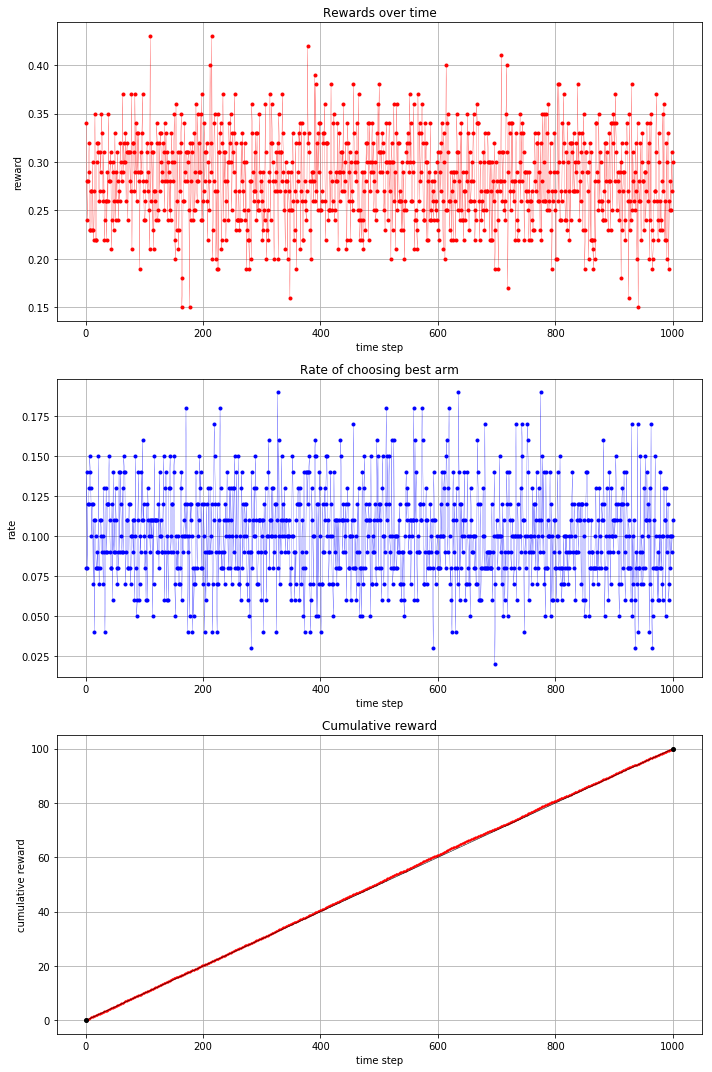

In [67]:
params = {"lr": 0.01}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

## Experimenting with several actor data on same plot

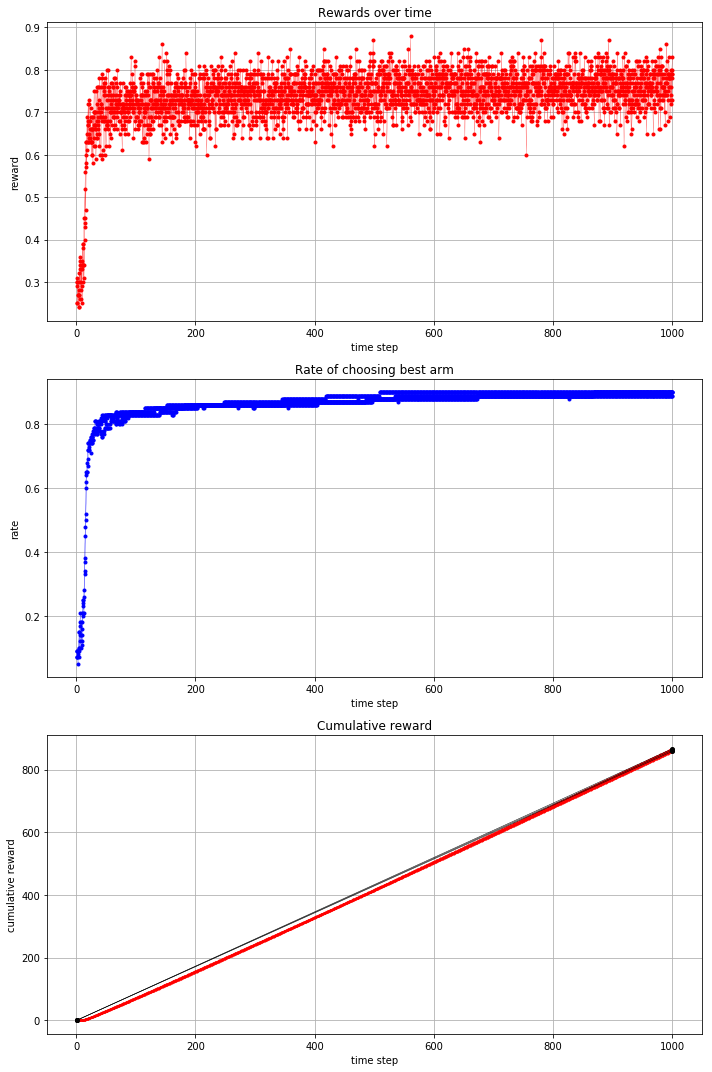

In [453]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent,agent,agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

# down

[go up](#up)